In [1]:
import numpy as np
import copy
import pickle
import os
import matplotlib.pyplot as plt
import random
import networkx as nx
import seaborn as sns
import sympy
import pandas as pd

import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import chi2_contingency

sns.set_theme(style="white", font='Times New Roman')
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.default'] = 'regular'

color_map = ['#FFFFFF','#FF5733']
color1 = 'darkviolet'
color2 = 'indigo'

#plt.rcParams['font.sans-serif']=['SimHei']
#plt.rcParams['axes.unicode_minus'] = False

# Input Settings

In [2]:
## 初始化
seed = 19980210
size = [100,100]
overlap_size = 20
p = 0.50            # 社团内部连接概率
q = 0.20            # 社团之间连接概率
niter = 10
vsteps = 100
trial = 1
beta1 = 1.0
beta2 = 1.0
xi = 1.0
repeat = 1
knowp = True

In [298]:
## 初始化
seed = 19980210
size = [10,10]
overlap_size = 4
p = 0.50            # 社团内部连接概率
q = 0.20            # 社团之间连接概率
niter = 10
vsteps = 100
trial = 1
beta1 = 1.0
beta2 = 1.0
xi = 1.0
repeat = 1
knowp = True

In [327]:
## K = 3，完全恢复

'''
n * (np.sqrt(p)-np.sqrt(q))**2 / np.log(n) = 1.6
n * q / np.log(n) = 32 
'''

seed = 19931028
size = [300,300,300]
p = 0.60            # 社团内部连接概率
q = 0.30            # 社团之间连接概率
niter = 10
vsteps = 100
trial = 1
beta1 = 1.0
beta2 = 1.0
xi = 1.0
#repeat = 1
knowp = True

In [435]:
'''
非平衡网络
'''
Pstar_unbal = np.array([[0.5 , 0.29, 0.35, 0.25],
       [0.29, 0.45, 0.25, 0.3 ],
       [0.35, 0.25, 0.5 , 0.35],
       [0.25, 0.3 , 0.35, 0.45]])

# Initialization

In [3]:
R = np.diag(size)
K = R.shape[0]
n = np.sum(R)
c = np.repeat(np.arange(K), np.sum(R, axis=0))
#overlap_num = 10
#c[int(n/2 - overlap_num/2): int(n/2)] = 2
#c[-int(overlap_num/2):] = 2

In [4]:
## 连接概率矩阵
Pstar = q * np.ones([K, K]) + np.diag((p - q) * np.ones(K))
Pstar

array([[0.5, 0.2],
       [0.2, 0.5]])

In [ ]:
Pstar = Pstar_unbal
Pstar

In [5]:
'''
暂时用不上模块度
'''
## modularity模块度计算
def Q(adjacency_matrix, cluster): 
    #总边数
    m =sum(sum(adjacency_matrix))/2       #总边数
    k1 = np.sum(adjacency_matrix,axis=1)  #各个点的边数
    k2 = k1.reshape(k1.shape[0],1)        #将列表拆分成每个数一个列表
    #节点度数积
    k1k2 = k1*k2
    #任意两点连接边数的期望值
    Eij = k1k2/(2*m)
    #节点v和w的实际边数与随机网络下边数期望之差
    B = adjacency_matrix - Eij
    #获取节点、社区矩阵
    node_cluster = np.dot(cluster,np.transpose(cluster))
    results = np.dot(B,node_cluster)
    #求和
    sum_results = np.trace(results)
    #模块度计算
    Q = sum_results / (2 * m)
    print("Q:",Q)
    return Q

In [6]:
## 将组标签扩展，得到节点数*组数的矩阵，每行代表一个节点，第几个位置为1即分为第几组
## 返回结果：每个节点都是一个数组，属于的组为1，其余为0
def Zform(e, K):
    n = len(e)  #e是节点的分组列表community assgnment，n即为网络大小，共n个节点
    Ze = np.zeros((n, K))  #生成n*K的0矩阵（初始矩阵）
    Ze[np.arange(n), e] = 1  #对每个节点（每行）打标签
    return Ze

In [7]:
Zc = Zform(c, K)
avg_n = int(n/K)
avg_overlap = int(overlap_size/K)
for i in range(avg_n - avg_overlap, avg_n):
    Zc[i][1] = 1
for i in range(avg_n*K - avg_overlap, avg_n*K):
    Zc[i][0] = 1

In [13]:
## 根据连边概率生成邻接矩阵A
def genA_2communities():
    #Zc = Zform(c, K)  #输入c和组数K，得到扩展的分组矩阵
    Zc = Zform(c, K)
    avg_n = int(n/K)
    avg_overlap = int(overlap_size/K)
    for i in range(avg_n - avg_overlap, avg_n):
        Zc[i][1] = 1
    for i in range(avg_n*K - avg_overlap, avg_n*K):
        Zc[i][0] = 1
    #Omega = np.matmul(np.matmul(Zc, Pstar), np.transpose(Zc))  #Pstar为转移矩阵（p和q未知的情况下，非平衡sbm）
    Omega = np.matmul(Zc, np.transpose(Zc))
    Omega[Omega > 0] = p
    Omega[Omega == 0] = q
    A = np.random.binomial(1, Omega)  #二项分布中采样1个数，Omega为取“正”的概率
    tmp = np.triu(A) - np.diag(np.diag(A))  #A的右上三角阵减去A的特征值
    A = tmp + np.transpose(tmp)
    return A

In [14]:
A = genA_2communities()

In [15]:
A

array([[0, 1, 1, ..., 1, 0, 1],
       [1, 0, 1, ..., 1, 0, 0],
       [1, 1, 0, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]])

In [10]:
'''
保存邻接矩阵
'''
'''
#A = genA()
AdjacentMatrix_dir = 'E:/学习/研三/Code/threshold_general'
pd.DataFrame(A).to_csv(AdjacentMatrix_dir + '/' + 'seed' + str(seed) + 'p' + str(p) + '.csv', header=True, index=False)
'''

"\n#A = genA()\nAdjacentMatrix_dir = 'E:/学习/研三/Code/threshold_general'\npd.DataFrame(A).to_csv(AdjacentMatrix_dir + '/' + 'seed' + str(seed) + 'p' + str(p) + '.csv', header=True, index=False)\n"

In [11]:
'''
旧的组标签形式进行单点移动
'''
## 任取一个点，将其移动到别的组，返回值为各个节点的组序号（更新后），被更新的节点标签，被更新的节点原始组，被更新的节点新组
def updateK(e, K):
    newe = copy.deepcopy(e)  #确保多维列表复制成功
    n = len(newe)  #newe的长度
    setfull = list(range(K))  #制作一个组数K的list，setfull包含所有可能的组标签
    ind = np.random.randint(n)  #在newe中抽取一个数
    b = newe[ind]  #找到随机数在newe中的位置
    
    del setfull[newe[ind]]  #删除setfull中相应位置
    b_prime = np.random.choice(setfull)  #b'，从组列表中抽取一个其他的编号
    
    
    newe[ind] = b_prime  #更新被抽取点的组标签
    return newe, ind, b, b_prime  #返回

In [16]:
'''
新的组标签形式进行块标记的flip
'''
## 任取一个点，将其移动到别的组，返回值为各个节点的组序号（更新后），被更新的节点标签，被更新的节点原始组，被更新的节点新组
def updateK(Ze, K):
    newZe = copy.deepcopy(Ze)  #确保多维列表复制成功
    n = len(newZe)             #newe的长度
    setfull = list(range(K))   #制作一个组数K的list，setfull包含所有可能的组标签
    
    ind = np.random.randint(n)  #在newe的长度（即为点数n）中抽取一个数
    b = Ze[ind]                 #找到随机数在Ze中的位置（防止随着newZe的更新而更新）
    b_prime = copy.deepcopy(b)
    
    tag_number = int(sum(b))
    if tag_number == 0:
        print("不属于任何社团，程序出错")
        
    # 当节点只属于一个组时，tag只能进行add and change
    elif tag_number == 1:
        tag = np.where(b==1)[0][0]
        del setfull[tag]  #setfull中无法选中tag_old，只能取另一个组标签
        
        tag_flip = np.random.choice(setfull)  #进行flip的另一个组标签
        b_prime[tag_flip] += 1
        newZe[ind] = b_prime   #更新被抽取点的组标签
    else:
        tag_flip = np.random.choice(setfull)  #b'，从组列表中抽取一个其他的编号
        if b[tag_flip] == 1:
            b_prime[tag_flip] -= 1
        else:
            b_prime[tag_flip] += 1
        newZe[ind] = b_prime   #更新被抽取点的组标签
    return newZe, ind, b, b_prime, tag_flip  #返回

In [23]:
## 误差矩阵（混淆矩阵），Ze是扰乱后的扩展组标签，Zc是原本的扩展组标签，得到的矩阵为扰动前后判断矩阵
def Rdiff(e, c):
    K = np.max(c) + 1
    Ze = Zform(e, K)  #扰乱后的扩展组标签
    Zc = Zform(c, K)  #原本的扩展组标签
    R = np.matmul(np.transpose(Ze), Zc).astype(int)  #原本1，扰动后1；原本2，扰动后1；原本1，扰动后2；原本2，扰动后2
    return R

In [42]:
Ze0 = np.zeros((n, K)).astype(int)   # 生成n*n的0矩阵
ind0 = np.array(range(n))            # 长度为n的序列
start_flip_list = np.random.randint(K, size=(n))   # 初始随机将每个点分配进1个组，此时无重叠
for i in range(n):
    Ze0[ind0[i]][start_flip_list[i]] += 1

In [89]:
np.matmul(
    np.matmul(
        np.transpose(curr_Ze), np.ones([n, n])), curr_Ze
)

array([[10404.,  9996.],
       [ 9996.,  9604.]])

In [123]:
# 打乱
curr_Ze = copy.deepcopy(Ze0)  #深复制一个打乱后的标签
# 当某个点同时处于多个社团时，需要减去它与其他重叠块的块间连边数
curr_matO = np.matmul(
    np.matmul(np.transpose(curr_Ze), A), curr_Ze)   # 当点i属于块j时，与各个社团的连边数量
curr_matN = np.matmul(
    np.matmul(
        np.transpose(curr_Ze), np.ones([n, n])), curr_Ze
) - np.diag(np.sum(curr_Ze, axis=0))                # 可能出现的最大连边数量减去已经出现的连边数量，即为未连接的边数量

In [125]:
#newZe, ind, b, b_prime, tag_flip = updateK(Ze, K)
newZe, ind, b, b_prime, tag_flip = updateK(curr_Ze, K)
print(newZe, ind, b, b_prime, tag_flip)

[[1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]

In [ ]:
new_matN = matN.copy()
nZe = Ze.sum(axis=0)
del setfull[tag_flip]
for i in setfull:
    if b[i] == 1:
        new_matN[i][tag_flip] -= nZe[tag_flip]*direct_coef
        new_matN[tag_flip][i] -= nZe[tag_flip]*direct_coef
    elif b[i] == 0:
        new_matN[i][tag_flip] += nZe[tag_flip]*direct_coef
        new_matN[tag_flip][i] += nZe[tag_flip]*direct_coef
        
new_matN[tag_flip][tag_flip] += tmp[tag_flip]*direct_coef

In [135]:
new_matO = curr_matO.copy()
new_matN = curr_matN.copy()
nZe = curr_Ze.sum(axis=0)

setfull = list(range(K))
del setfull[tag_flip]
for i in setfull:
    if b[i] == 1:
        new_matO[i][tag_flip] -= tmp[tag_flip]*direct_coef
        new_matO[tag_flip][i] -= tmp[tag_flip]*direct_coef
        new_matN[i][tag_flip] -= nZe[tag_flip]*direct_coef
        new_matN[tag_flip][i] -= nZe[tag_flip]*direct_coef
    elif b[i] == 0:
        new_matO[i][tag_flip] += tmp[tag_flip]*direct_coef
        new_matO[tag_flip][i] += tmp[tag_flip]*direct_coef
        new_matN[i][tag_flip] += nZe[tag_flip]*direct_coef
        new_matN[tag_flip][i] += nZe[tag_flip]*direct_coef

new_matO[tag_flip][tag_flip] += tmp[tag_flip]*direct_coef
new_matN[tag_flip][tag_flip] += nZe[tag_flip]*direct_coef*2

In [133]:
## 根据节点移动情况更新网络连边情况
def updateMat(matO, matN, ind, b, b_prime, Ze, tag_flip):
    A_ind = A[ind, ].reshape((-1, 1))                    #被选取点的连边情况
    tmp = (A_ind * Ze).sum(axis=0)  # dim: k             #和每块的连边数量
    new_matO = matO.copy()          # 当前已有连边数矩阵
    new_matN = matN.copy()          # 最大可能连边数矩阵
    nZe = Ze.sum(axis=0)
    
    setfull = list(range(K))
    del setfull[tag_flip]
    for i in setfull:
        if b[i] == 1:
            new_matO[i][tag_flip] -= tmp[tag_flip]*direct_coef
            new_matO[tag_flip][i] -= tmp[tag_flip]*direct_coef
            new_matN[i][tag_flip] -= nZe[tag_flip]*direct_coef
            new_matN[tag_flip][i] -= nZe[tag_flip]*direct_coef
        elif b[i] == 0:
            new_matO[i][tag_flip] += tmp[tag_flip]*direct_coef
            new_matO[tag_flip][i] += tmp[tag_flip]*direct_coef
            new_matN[i][tag_flip] += nZe[tag_flip]*direct_coef
            new_matN[tag_flip][i] += nZe[tag_flip]*direct_coef

    new_matO[tag_flip][tag_flip] += tmp[tag_flip]*direct_coef
    new_matN[tag_flip][tag_flip] += nZe[tag_flip]*direct_coef*2
    return new_matO, new_matN

In [138]:
## 后验分布计算方法
def loggam_apprx(x):
    tmp = (x + 1 / 2) * np.log(x) - x + 1 / 2 * np.log(2 * np.pi)
    return tmp

In [139]:
## 对数后验分布的快速计算，输入为连边数，可能出现的最大连边数
def logpostpdf_fast(matO, matN):
    matY = matN - matO
    p = np.sum(
        loggam_apprx(matO + beta1 - 1) +
        loggam_apprx(matY + beta2 - 1) -
        loggam_apprx(matN + beta1 + beta2 - 2)
    ) / 2
    return p

In [26]:
'''
输入为4*9000的格式
输出为1*9000的格式
相当于每4步记录一个值，降低采样前后相关性
'''
def autocorrelation_list(logpost_each_test, step):
    logpost_concact = []
    for i in range(len(logpost_each_test)):
        for j in range(len(logpost_each_test[i])):
            logpost_concact.append(logpost_each_test[i][j])

    logpost_simple = []
    for _ in range(int(len(logpost_concact) / step)):
        logpost_simple.append(logpost_concact[_ * step])
    return logpost_simple

In [27]:
## 在一次恢复中，对某个特定tau值计算对应的Rtau
def Rtau_onetau(logpost_list, tau):
    #Rtau_list = []
    T = len(logpost_list)
    scale_para = T - tau
    logpost_avg = np.mean(logpost_list)
    logpost_std = np.std(logpost_list)
    logpost_sigma = logpost_std ** 2
    Rtau = 0
    for i in range(1, scale_para):
        Rtau += (logpost_list[i] - logpost_avg) * (logpost_list[i+tau] - logpost_avg) / scale_para / logpost_sigma
        #Rtau_list.append(Rtau)
    return Rtau

In [28]:
## 对某次特定恢复进行分析，遍历所有tau值
def Rtau_onerecover(logpost_list):
    Rtau_onerecover_list = []
    Rtau_star = 0
    T_prime = 0
    for _ in range(len(logpost_list)-1):
        Rtau_temp = Rtau_onetau(logpost_list, _)
        Rtau_onerecover_list.append(Rtau_temp)
        if Rtau_temp > 0:
            Rtau_star += Rtau_temp
            T_prime += 1
    return Rtau_onerecover_list, Rtau_star, T_prime

In [29]:
## 对Rtau按恢复情况进行划分，计算不同恢复结果的平均收敛时间
def Rtau_star_cut_list(Rtau_star_list, RI_list):
    count_range = [0.4, 0.75, 0.85, 1.0]
    cut1_list = []
    cut2_list = []
    cut3_list = []
    for i in range(repeat):
        if count_range[0] < RI_list[i] <= count_range[1]:
            cut1_list.append(Rtau_star_list[i])
        elif count_range[1] < RI_list[i] <= count_range[2]:
            cut2_list.append(Rtau_star_list[i])
        else:
            cut3_list.append(Rtau_star_list[i])
    return cut1_list, cut2_list, cut3_list

In [30]:
def cut_list(lists, cut_len):
    """
    将列表拆分为指定长度的多个列表
    :param lists: 初始列表
    :param cut_len: 每个列表的长度
    :return: 一个二维数组 [[x,x],[x,x]]
    """
    res_data = []
    if len(lists) > cut_len:
        for i in range(int(len(lists) / cut_len)):
            cut_a = lists[cut_len * i:cut_len * (i + 1)]
            res_data.append(cut_a)

        last_data = lists[int(len(lists) / cut_len) * cut_len:]
        if last_data:
            res_data.append(last_data)
    else:
        res_data.append(lists)

    return res_data

In [31]:
'''
已停用，画图颜色直接由RI_index决定
'''
'''
输入整合后的logpost，是某个特定p值下的50次恢复情况
数据量p_range*repeat*niter
输出整个所有情况下后验的最大值，最小值和当前p值下后验分布最终值
'''
def logpost_color(logpost_simple_list):
    df_bound = pd.DataFrame(logpost_simple_list)
    logpost_upperbound = np.max(df_bound.iloc[:,-1])
    logpost_lowerbound = np.min(df_bound.iloc[:,-1])
    color_array = (df_bound.iloc[:,-1] - logpost_lowerbound) / (logpost_upperbound - logpost_lowerbound)
    return logpost_upperbound, logpost_lowerbound, color_array

In [32]:
'''
y表示p或q其中某一个值，求另一个
'''
def detection_threshold(n, y):
    x = sympy.Symbol('x')
    I = -2 * sympy.log(sympy.sqrt(x)*(round(sympy.sqrt(y), 5)) + sympy.sqrt(1-x)*round(sympy.sqrt(1-y), 5))
    equation = n*I - 2*round(sympy.log(n), 5)
    threshold = sympy.solve(equation, x)
    return threshold

In [33]:
'''
y表示p或q其中某一个值，求另一个
PRL中的另一种识别阈值求法
'''
def detection_threshold2(n, y, K):
    x = sympy.Symbol('x')
    left1 = x - y
    right1 = sympy.sqrt(K*x + K*(K-1)*y) / sympy.sqrt(n)
    equation = left1 - right1
    threshold = sympy.solve(equation, x)
    return threshold

In [34]:
def RIindex(e0, true_label):
    a = b = c = d = 0
    for i in range(len(e0)):
        for j in range(i, len(e0)):
            if e0[i] == e0[j]:
                if true_label[i] == true_label[j]:
                    a += 1
                else:
                    c += 1
            else:
                if true_label[i] == true_label[j]:
                    d += 1
                else:
                    b += 1
    RI = (a + b) / (a + b + c + d)
    return RI

In [35]:
'''
计算每个参数下50次恢复中的恢复情况出现频次
'''
def RI_frequency_list(RI_list):
    count_range = np.linspace(0.5, 1.0, 6)
    count_list = np.zeros((5, )).astype(int)
    for i in RI_list:
        for l in range(len(count_range)):
            if count_range[l] < i < count_range[l+1]:
                count_list[l] += 1
            else:
                l += 1
    return count_list

In [36]:
'''
计算每个参数下50次恢复中的恢复情况出现频次
'''
def RI_frequency_list2(RI_list):
    count_range = [0.5, 0.7, 1.0]
    count_list = np.zeros((3, )).astype(int)
    for i in RI_list:
        for l in range(len(count_range)):
            if count_range[l] < i < count_range[l+1]:
                count_list[l] += 1
            else:
                l += 1
    return count_list

In [37]:
def RI_frequency_count(RI_list):
    count_range = np.linspace(0.5, 1.0, 6)
    count_list = np.zeros((5, )).astype(int)
    for i in RI_list:
        for l in range(len(count_range)):
            if count_range[l] < i <= count_range[l+1]:
                count_list[l] += 1
            else:
                l += 1
    return count_list

In [38]:
def RI_frequency_count2(RI_list):
    count_range = [0.4, 0.75, 0.85, 1.0]
    count_list = np.zeros((3, )).astype(int)
    for i in RI_list:
        for l in range(len(count_range)):
            if count_range[l] < i <= count_range[l+1]:
                count_list[l] += 1
            else:
                l += 1
    return count_list

In [39]:
def RI_frequency_countpq(RI_list):
    count_range = np.linspace(0.5, 1.0, 11)
    count_list = np.zeros((10, )).astype(int)
    for i in RI_list:
        for l in range(len(count_range)):
            if count_range[l] < i <= count_range[l+1]:
                count_list[l] += 1
            else:
                l += 1
    return count_list

In [40]:
def RI_frequency_countnp(RI_list):
    count_range = np.linspace(0.5, 1.0, 11)
    count_list = np.zeros((10, )).astype(int)
    for i in RI_list:
        for l in range(len(count_range)):
            if count_range[l] < i <= count_range[l+1]:
                count_list[l] += 1
            else:
                l += 1
    return count_list

In [41]:
## 最佳恢复情况，算法的识别能力
def bestRI_to_Q(finalRI_list, finalR_list, p_index):
    max_index = np.array(finalRI_list[p_index]).argmax()
    finalR = finalR_list[p_index][max_index]
    
    a = finalR[0][0] + finalR[1][1]
    b = finalR[0][1] + finalR[1][0]
    correct_number = np.max((a, b))
    correct_ratio = correct_number / n
    Q = (correct_ratio - 1/K) / (1 - 1/K)
    return correct_number, Q, max_index

In [43]:
def mistake_rate(R_list):
    repeat = len(R_list)
    mistake_list = []
    for i in range(repeat):
        mis_matrix = R_list[i]
        mistake = n - np.sum(np.max(mis_matrix, axis=0) + np.max(mis_matrix, axis=1)) / 2
        max_mistake = n - n / K 
        mistake_list.append(1 - mistake / max_mistake)
    return np.mean(mistake_list)

In [44]:
def mistake_rate_detail(R_list):
    repeat = len(R_list)
    mistake_list = []
    for i in range(repeat):
        mis_matrix = R_list[i]
        mistake = n - np.sum(np.max(mis_matrix, axis=0) + np.max(mis_matrix, axis=1)) / 2
        max_mistake = n - n / K 
        mistake_list.append(1 - mistake / max_mistake)
    return mistake_list

# MCMC Algorithm

In [133]:
## 根据节点移动情况更新网络连边情况
def updateMat(matO, matN, ind, b, b_prime, Ze, tag_flip):
    A_ind = A[ind, ].reshape((-1, 1))                    #被选取点的连边情况
    tmp = (A_ind * Ze).sum(axis=0)  # dim: k             #和每块的连边数量
    new_matO = matO.copy()          # 当前已有连边数矩阵
    new_matN = matN.copy()          # 最大可能连边数矩阵
    nZe = Ze.sum(axis=0)
    
    setfull = list(range(K))
    del setfull[tag_flip]
    for i in setfull:
        if b[i] == 1:
            new_matO[i][tag_flip] -= tmp[tag_flip]*direct_coef
            new_matO[tag_flip][i] -= tmp[tag_flip]*direct_coef
            new_matN[i][tag_flip] -= nZe[tag_flip]*direct_coef
            new_matN[tag_flip][i] -= nZe[tag_flip]*direct_coef
        elif b[i] == 0:
            new_matO[i][tag_flip] += tmp[tag_flip]*direct_coef
            new_matO[tag_flip][i] += tmp[tag_flip]*direct_coef
            new_matN[i][tag_flip] += nZe[tag_flip]*direct_coef
            new_matN[tag_flip][i] += nZe[tag_flip]*direct_coef

    new_matO[tag_flip][tag_flip] += tmp[tag_flip]*direct_coef
    new_matN[tag_flip][tag_flip] += nZe[tag_flip]*direct_coef*2
    return new_matO, new_matN

In [46]:
def SingleFlip_MHsampler(e0=None, niter=None, knowp=False, vsteps=100):
    '''
    Args:
        e0: init
        niter: total # of iterations
        K: # of class
        beta1, beta2: hyper-param
        A: adjacency matrix
        xi: temperature
        c: true label assignment
    '''

    
    # 打乱
    curr_Ze = copy.deepcopy(Ze0)  #深复制一个打乱后的标签
    # 当某个点同时处于多个社团时，需要减去它与其他重叠块的块间连边数
    curr_matO = np.matmul(
        np.matmul(np.transpose(curr_Ze), A), curr_Ze)   # 当点i属于块j时，与各个社团的连边数量
    curr_matN = np.matmul(
        np.matmul(
            np.transpose(curr_Ze), np.ones([n, n])), curr_Ze
    ) - np.diag(np.sum(curr_Ze, axis=0))                # 可能出现的最大连边数量减去已经出现的连边数量，即为未连接的边数量

    # 储存当前（打乱后的）后验分布
    logPost = []
    logPost.append(logpostpdf_fast(curr_matO, curr_matN))
    # logPost.append(self.logpostpdf(e0, knowp))
    n_mis = []

    # 开始循环
    for i in np.arange(1, niter):
        new_Ze, ind, b, b_prime, tag_flip = updateK(curr_Ze, K)  #任取一个点，将其移动到别的组，返回新的标签，被移动点，移动前后的组号
        # new_e, ind, b, b_prime = updateK_L(curr_e, 0)
        new_matO, new_matN = updateMat(              #更新网络的连边数量
             curr_matO, curr_matN, ind, b, b_prime, curr_Ze, tag_flip)
        
        
        # logNew = self.logpostpdf(newe, knowp)
        logNew = logpostpdf_fast(new_matO, new_matN)  #节点移动后的对数后验分布
        logdiff = logNew - logPost[i - 1]                  #计算新的后验分布与前一次后验分布的差值
        tmp = np.random.uniform(0, 1)                      #选取随机数

        # 判断是否接受这次移动，保存当前组标签和对数后验分不
        if tmp < np.exp(xi * logdiff):
            curr_Ze = new_Ze
            curr_matO, curr_matN = new_matO, new_matN
            logPost.append(logNew)

        else:
            logPost.append(logPost[i - 1])

        # if i % vsteps == 0:
        #     R = Rdiff(currente, self.c)
        #     mist = np.sum(R - np.diag(np.diag(R)))
        #     print("iteration: {}, mistake: {}".format(i, mist))
        #     if self.show:
        #         print(R)
        #     n_mis.append(mist)


    logPost = logPost
    label = curr_Ze
    n_mis = n_mis
    finalR = Rdiff(curr_e, c)
    return logPost, label, n_mis, finalR

# Main

classic_MHsampler

In [47]:
niter = niter * n
niter

2000

In [48]:
test_num = 0
dirmake = "./K" + str(K) + "n" + str(n) + "p" + str(p) + "q" + str(q) + "/"
if not os.path.exists(dirmake):
    os.makedirs(dirmake)

In [49]:
repeat = 50

In [50]:
## main for classic_MHsampler
logpost_save = []
initR_each_repeat_save = []
alginitR_save = []
finalR_save = []
finale_save = []
finalRI_save = []

for repeat_mark in range(repeat):
    Ze0 = np.zeros((n, K)).astype(int)   # 生成n*n的0矩阵
    start_flip_list = np.random.randint(K, size=(n))   # 初始随机将每个点分配进1个组，此时无重叠
    for i in range(n):
        Ze0[ind[i]][start_flip_list[i]] += 1
    alginitR = Rdiff(e0, c)  #更新错误矩阵
    alginitR_save.append(alginitR)
    print("initial alginitR: ", alginitR)

    logPostList = []
    misList = []
    # labelList = []
    count = 1
    RList = []
    initR = alginitR
    initR_save = []

    while np.sum(initR - np.diag(np.diag(initR))) > 0 and count < 5:
        initR = Rdiff(e0, c)
        print("initial mistake is {}".format(
            np.sum(initR - np.diag(np.diag(initR)))))
        initR_save.append(np.sum(initR - np.diag(np.diag(initR))))

        res = classic_MHsampler(e0, niter, knowp, vsteps)
        e0 = res[1]
        logPostList.append(res[0])
        misList.append(res[2])
        RList.append(res[3])
        count = count + 1

    initR_each_repeat_save.append([initR_save])
    finalR = Rdiff(e0, c)
    mist = np.sum(finalR - np.diag(np.diag(finalR)))

    finale = e0
    RI = RIindex(finale, c)

    finale_save.append(finale)
    finalRI_save.append(RI)
    logpost_save.append(logPostList)
    finalR_save.append(finalR)


with open(dirmake + "input_repeat" + str(repeat_mark) + ".pkl", "wb") as out:
    pickle.dump(
        [K, n, niter, Pstar, alginitR], out)

# save_figs
with open(dirmake + "output_repeat" + str(repeat_mark) + ".pkl", "wb") as out:
    pickle.dump([logpost_save, initR_each_repeat_save, alginitR_save, finalR_save, finale_save, finalRI_save], out)

initial alginitR:  [[27 28  5]
 [38 26  2]
 [30 41  3]]
initial mistake is 144
initial mistake is 200
initial mistake is 200
initial mistake is 199
initial alginitR:  [[30 35  2]
 [31 28  5]
 [34 32  3]]
initial mistake is 139
initial mistake is 198
initial mistake is 200
initial mistake is 200
initial alginitR:  [[29 38  7]
 [35 28  0]
 [31 29  3]]
initial mistake is 140
initial mistake is 148
initial mistake is 146
initial mistake is 143
initial alginitR:  [[38 25  2]
 [31 38  4]
 [26 32  4]]
initial mistake is 120
initial mistake is 182
initial mistake is 200
initial mistake is 200
initial alginitR:  [[32 40  3]
 [35 31  2]
 [28 24  5]]
initial mistake is 132
initial mistake is 193
initial mistake is 200
initial mistake is 200
initial alginitR:  [[35 38  2]
 [36 27  4]
 [24 30  4]]
initial mistake is 134
initial mistake is 196
initial mistake is 200
initial mistake is 200
initial alginitR:  [[29 33  3]
 [32 27  5]
 [34 35  2]]
initial mistake is 142
initial mistake is 195
initial mi

In [51]:
finalR_save

[array([[ 0,  0, 10],
        [95,  0,  0],
        [ 0, 95,  0]]),
 array([[ 0, 95,  0],
        [ 0,  0, 10],
        [95,  0,  0]]),
 array([[25, 21, 10],
        [34, 38,  0],
        [36, 36,  0]]),
 array([[ 1,  0, 10],
        [94,  0,  0],
        [ 0, 95,  0]]),
 array([[ 0,  0, 10],
        [95,  0,  0],
        [ 0, 95,  0]]),
 array([[ 0,  0, 10],
        [95,  0,  0],
        [ 0, 95,  0]]),
 array([[ 0,  0, 10],
        [95,  0,  0],
        [ 0, 95,  0]]),
 array([[ 0, 95,  0],
        [95,  0,  0],
        [ 0,  0, 10]]),
 array([[ 0,  0, 10],
        [ 0, 95,  0],
        [95,  0,  0]]),
 array([[95,  0,  0],
        [ 0, 95,  0],
        [ 0,  0, 10]]),
 array([[ 0, 95,  0],
        [95,  0,  0],
        [ 0,  0, 10]]),
 array([[95,  0,  0],
        [ 0,  0, 10],
        [ 0, 95,  0]]),
 array([[ 0, 95,  0],
        [ 0,  0, 10],
        [95,  0,  0]]),
 array([[ 0,  0, 10],
        [ 0, 95,  0],
        [95,  0,  0]]),
 array([[95,  0,  0],
        [ 0, 95,  0],
    

In [110]:
finallogpost_list_classic = []
finalR_list_classic = []
finale_list_classic = []
finalRI_list_classic = []
pkl_number = repeat - 1

datadir1 = "./K" + str(K) + "n" + str(n) + "p" + str(p) + "q" + str(q) + "/" + "output_repeat" + str(pkl_number)
data_temp = pickle.load(open(datadir1 + '.pkl','rb'))
#print(datadir)
finallogpost_list_classic.append(data_temp[0])
finalR_list_classic.append(data_temp[3])
finale_list_classic.append(data_temp[4])
finalRI_list_classic.append(data_temp[5])
#print(data_temp[3])

In [116]:
finalRI_list_classic

[[0.9948258706467662,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9896019900497512,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9948258706467662,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

# Figure Plot

## Classic_MH

In [63]:
p_range = [round(i,4) for i in np.linspace(0.30, 0.50, 101)]
repeat = 50

In [64]:
finallogpost_list_classic = []
finalR_list_classic = []
finale_list_classic = []
finalRI_list_classic = []
pkl_number = repeat - 1
for p in p_range:
    datadir1 = "E:/学习/研三/Code/threshold_classic" + "/" + "K" + str(K) + "n" + str(n) + "p" + str(p) + "q" + str(q) + "/" + "output_repeat" + str(pkl_number)
    data_temp = pickle.load(open(datadir1 + '.pkl','rb'))
    #print(datadir)
    finallogpost_list_classic.append(data_temp[0])
    finalR_list_classic.append(data_temp[3])
    finale_list_classic.append(data_temp[4])
    finalRI_list_classic.append(data_temp[5])
    #print(data_temp[3])

In [65]:
## 整合后的后验分布，len(p_range)*repeat*len(logpost)
logpost_simple_list_classic = []
for i in range(len(p_range)):
    logpost_simple_list_eachp = []
    for j in range(repeat):
        logpost_simple_list_eachp.append(autocorrelation_list(finallogpost_list_classic[i][j]))
    logpost_simple_list_classic.append(logpost_simple_list_eachp)

In [66]:
Rtau_list_classic = []
Rtau_star_classic = []
T_prime_classic = []
for p in p_range:
    datadir2 = "E:/学习/研三/Code/threshold_classic" + "/" + "K" + str(K) + "n" + str(n) + "p" + str(p) + "q" + str(q) + "/" + "converge_time" + str(repeat)
    data_temp = pickle.load(open(datadir2 + '.pkl','rb'))
    #print(datadir)
    Rtau_list_classic.append(data_temp[0])
    Rtau_star_classic.append(data_temp[1])
    T_prime_classic.append(data_temp[2])
    #print(data_temp[3])

In [39]:
data_classic_dir = "E:/学习/研三/Code/threshold_classic/Package_data/"

In [41]:
with open(data_classic_dir + "p" + str(p_range[0]) + "-" + str(p_range[-1]) + "logpost_simple_list_classic" + str(repeat) + ".pkl", "wb") as out:
    pickle.dump(logpost_simple_list_classic, out)

In [42]:
with open(data_classic_dir + "p" + str(p_range[0]) + "-" + str(p_range[-1]) + "finalR_list_classic" + str(repeat) + ".pkl", "wb") as out:
    pickle.dump(finalR_list_classic, out)
with open(data_classic_dir + "p" + str(p_range[0]) + "-" + str(p_range[-1]) + "finale_list_classic" + str(repeat) + ".pkl", "wb") as out:
    pickle.dump(finale_list_classic, out)
with open(data_classic_dir + "p" + str(p_range[0]) + "-" + str(p_range[-1]) + "finalRI_list_classic" + str(repeat) + ".pkl", "wb") as out:
    pickle.dump(finalRI_list_classic, out)

In [ ]:
with open(data_classic_dir + "p" + str(p_range[0]) + "-" + str(p_range[-1]) + "Rtau_list_classic" + str(repeat) + ".pkl", "wb") as out:
    pickle.dump(Rtau_list_classic, out)
with open(data_classic_dir + "p" + str(p_range[0]) + "-" + str(p_range[-1]) + "Rtau_star_classic" + str(repeat) + ".pkl", "wb") as out:
    pickle.dump(Rtau_star_classic, out)
with open(data_classic_dir + "p" + str(p_range[0]) + "-" + str(p_range[-1]) + "T_prime_classic" + str(repeat) + ".pkl", "wb") as out:
    pickle.dump(T_prime_classic, out)

In [ ]:
finallogpost_list_classic = []
finalR_list_classic = []
finale_list_classic = []
finalRI_list_classic = []
pkl_number = repeat - 1
for p in p_range:
    datadir1 = "E:/学习/研三/Code/threshold_classic" + "/" + "K" + str(K) + "n" + str(n) + "p" + str(p) + "q" + str(q) + "/" + "output_repeat" + str(pkl_number)
    finallogpost_list_classic = pickle.load(open(datadir1 + '.pkl','rb'))
    #print(datadir)
    .append(data_temp[0])
    finalR_list_classic.append(data_temp[3])
    finale_list_classic.append(data_temp[4])
    finalRI_list_classic.append(data_temp[5])
    #print(data_temp[3])

### 识别性分析

In [68]:
RI_frequency_classic = []
for i in range(len(p_range)):
    RI_frequency_classic.append(RI_frequency_count(finalRI_list_classic[i]))

In [75]:
RI_frequency_classic

[array([17,  5, 22,  1,  5]),
 array([24,  2, 16,  2,  6]),
 array([17,  0, 23,  0, 10]),
 array([12,  4, 19,  2, 13]),
 array([ 8,  1, 19,  3, 19]),
 array([17,  2, 20,  1, 10]),
 array([11,  2, 20,  1, 16]),
 array([12,  0, 18,  1, 19]),
 array([ 4,  3, 20,  3, 20]),
 array([ 5,  0, 25,  1, 19]),
 array([ 7,  1, 22,  0, 20]),
 array([ 6,  2, 23,  1, 18]),
 array([ 9,  1, 16,  2, 22]),
 array([ 9,  1, 12,  2, 26]),
 array([ 3,  0, 14,  3, 30]),
 array([ 5,  0, 18,  2, 25]),
 array([ 3,  3, 11,  3, 30]),
 array([ 5,  0, 24,  0, 21]),
 array([ 3,  1, 14,  0, 32]),
 array([ 4,  1, 22,  0, 23]),
 array([ 7,  2, 14,  0, 27]),
 array([ 7,  0, 23,  2, 18]),
 array([ 4,  0, 18,  1, 27]),
 array([ 1,  0, 22,  0, 27]),
 array([ 7,  1, 12,  1, 29]),
 array([ 2,  0, 15,  0, 33]),
 array([ 3,  1, 16,  1, 29]),
 array([ 4,  1, 15,  1, 29]),
 array([ 5,  0,  9,  2, 34]),
 array([ 5,  1, 20,  0, 24]),
 array([ 1,  1, 15,  1, 32]),
 array([ 4,  1, 10,  0, 35]),
 array([ 4,  0, 12,  2, 32]),
 array([ 5

In [70]:
#df_RI_frequency_meanfield = pd.DataFrame(RI_frequency_meanfield, index=p_range, columns=[0.55, 0.65, 0.75, 0.85, 0.95])
df_RI_frequency_classic = pd.DataFrame(np.transpose(RI_frequency_classic), index=[0.55, 0.65, 0.75, 0.85, 0.95], columns=p_range)
df_RI_frequency_classic = df_RI_frequency_classic.iloc[::-1]

In [71]:
df_RI_frequency_classic

,0.300,0.302,0.304,0.306,0.308,0.310,0.312,0.314,0.316,0.318,...,0.482,0.484,0.486,0.488,0.490,0.492,0.494,0.496,0.498,0.500
0.95,0,0,0,0,0,0,0,0,0,0,...,41,37,37,36,44,41,34,41,36,40
0.85,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0
0.75,0,0,0,0,0,0,0,0,0,0,...,8,8,11,11,3,8,14,7,13,10
0.65,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.55,50,50,50,50,50,50,50,50,50,50,...,1,4,2,2,3,0,2,2,1,0


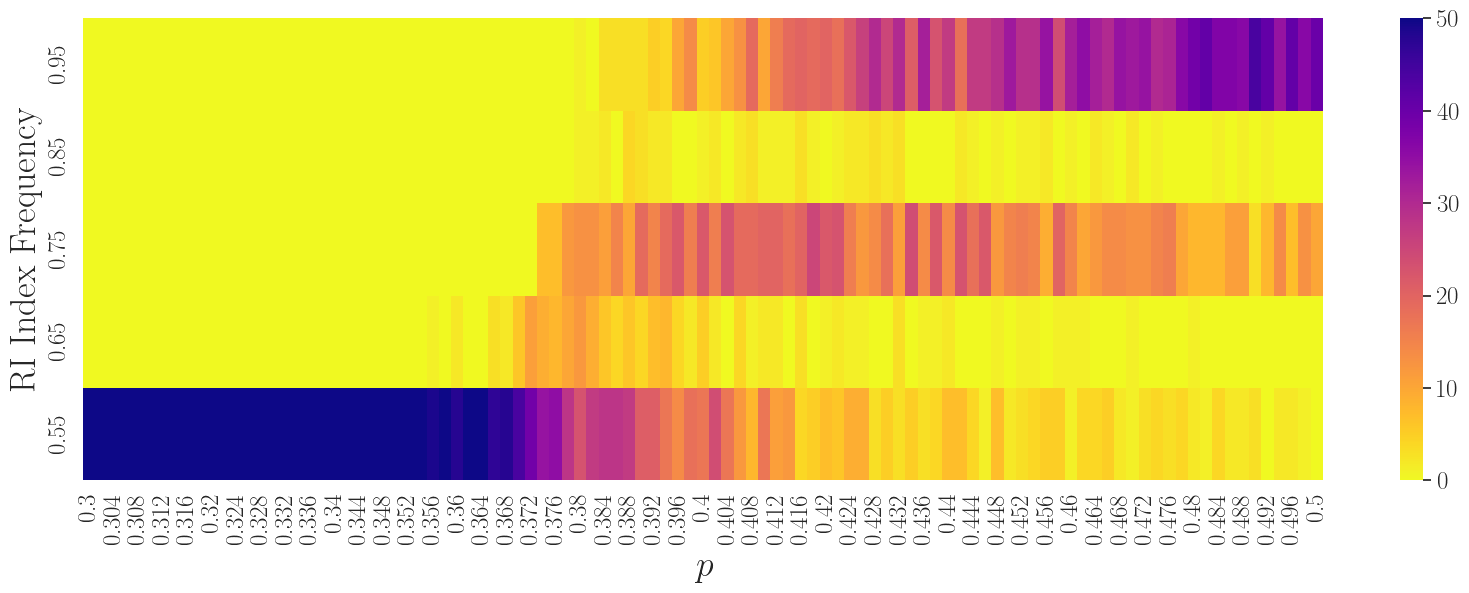

In [72]:
plt.figure(figsize=(20,6))
fig_name = 'n='+str(n) + ',' + 'p=' + str(p_range[0]) + '-' + str(p_range[-1]) + ',' + 'q='+str(q) +','+ 'repeat=' + str(repeat) + ',' + 'Classic_MH'+','+ "RI index frequency heatmap1"
#plt.title(fig_name)
ax = sns.heatmap(df_RI_frequency_classic, cmap="plasma_r", annot=False)

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize = 18)

plt.xlabel(r"$p$", fontsize = 26)
plt.ylabel("RI Index Frequency", fontsize = 26)
save_file = "E:/学习/研三/Code/threshold_classic" + "/" + fig_name + ".jpg"
#plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

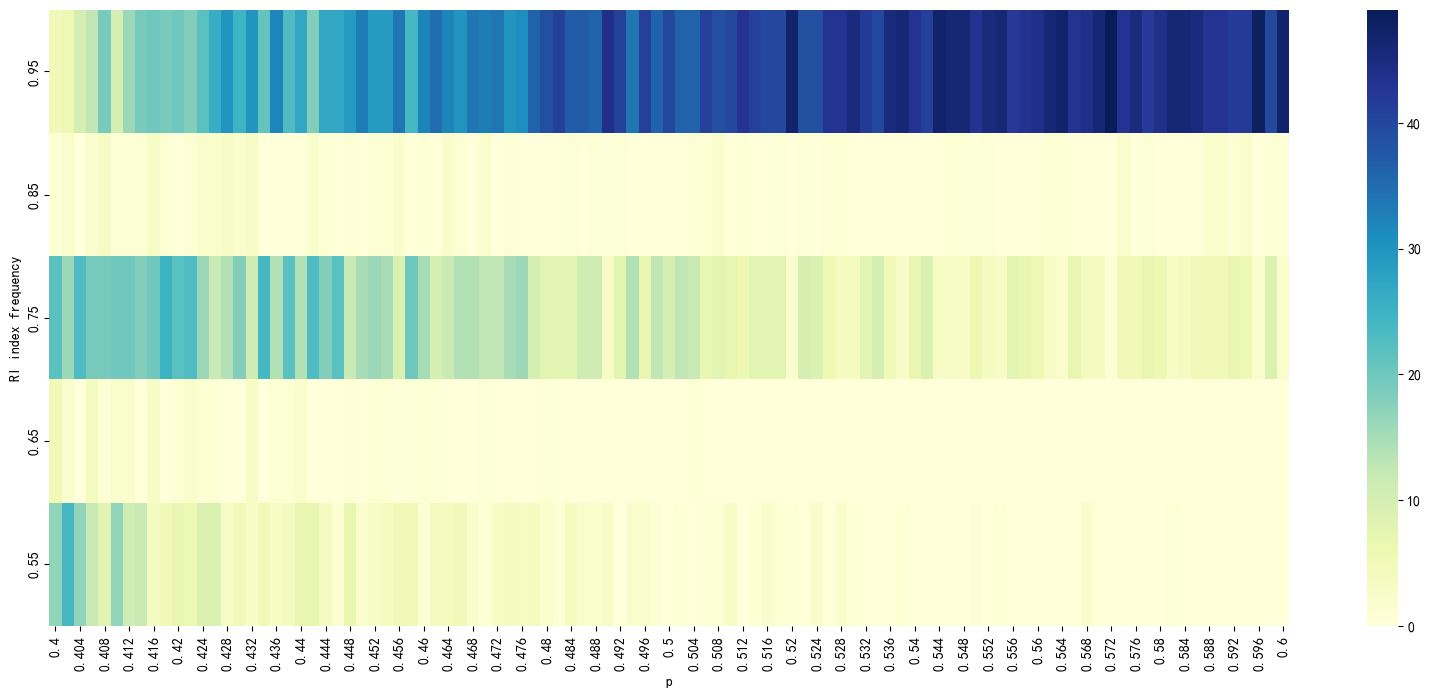

In [125]:
'''
另一套配色，已停用
'''
plt.figure(figsize=(20,8))
fig_name = 'n='+str(n) + ',' + 'p=' + str(p_range[0]) + '-' + str(p_range[-1]) + ',' + 'q='+str(q) +','+ 'repeat=' + str(repeat) + ',' + 'Classic_MH'+','+ "RI index frequency heatmap2"
plt.xlabel('p')
#plt.ylabel('RI index')
#plt.title(fig_name)
sns.heatmap(df_RI_frequency_classic, cmap="YlGnBu", annot=False)
save_file = "E:/学习/研三/Code/threshold_classic" + "/" + fig_name + ".jpg"
plt.xlabel("p")
plt.ylabel("RI index frequency")
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

### 收敛性分析

In [39]:
'''
总共101个参数下进行恢复实验
'''
len(finallogpost_list_classic)

51

In [40]:
'''
每个参数下进行50次恢复
后续应该对50次的收敛时间进行分析，可以得到在不同参数下的平均收敛速度
'''
len(finallogpost_list_classic[0])

50

In [41]:
'''
每次恢复中重复4轮采样，共4*n*10次采样
'''
len(finallogpost_list_classic[0][0])

4

In [42]:
'''
每轮轮n*10次
'''
len(finallogpost_list_classic[0][0][0])

9000

In [83]:
len(logpost_simple_list_classic)

51

In [84]:
len(logpost_simple_list_classic[0])

50

In [45]:
pd.DataFrame(logpost_simple_list_classic[0])

,0,1,2,3,4,5,6,7,8,9,...,8990,8991,8992,8993,8994,8995,8996,8997,8998,8999
0,-257197.407055,-257197.539872,-257197.289474,-257197.073572,-257196.446916,-257196.412472,-257196.780706,-257196.686419,-257196.469035,-257196.240121,...,-256270.213060,-256270.481730,-256270.249555,-256269.428081,-256269.286288,-256267.215944,-256267.215944,-256267.215944,-256263.038732,-256263.322674
1,-257198.900857,-257198.896359,-257199.159462,-257198.847539,-257198.877479,-257198.765906,-257198.471601,-257198.335003,-257198.327150,-257198.350776,...,-256205.866844,-256206.719834,-256206.719834,-256206.832288,-256206.201515,-256206.353087,-256205.983490,-256205.829008,-256205.829008,-256206.603147
2,-257198.119797,-257198.088538,-257197.909548,-257198.109388,-257198.099540,-257198.249577,-257198.153167,-257198.089836,-257198.140212,-257198.201094,...,-256151.560683,-256151.864216,-256152.251364,-256152.487927,-256152.487927,-256152.175873,-256152.175873,-256151.948172,-256151.894257,-256151.381045
3,-257194.050421,-257194.054632,-257194.719531,-257195.037836,-257194.691036,-257194.307157,-257193.521621,-257195.054933,-257194.956318,-257195.143482,...,-257139.274849,-257139.710543,-257140.763256,-257140.639816,-257140.988377,-257139.507975,-257139.980437,-257139.820530,-257139.777191,-257139.060473
4,-257197.254069,-257197.168065,-257197.540457,-257197.243764,-257197.528062,-257197.448070,-257197.359797,-257197.475235,-257197.405513,-257197.336749,...,-256117.355239,-256117.355239,-256116.606046,-256117.237405,-256118.115042,-256118.253472,-256118.032635,-256118.032635,-256117.434639,-256117.434639
5,-257198.534711,-257198.599645,-257198.393364,-257198.351156,-257198.366662,-257198.465307,-257198.421966,-257198.683171,-257198.825419,-257198.957686,...,-256144.149562,-256144.040522,-256143.387604,-256143.125588,-256142.805151,-256142.744123,-256142.268164,-256142.299591,-256142.426568,-256142.876737
6,-257195.403326,-257195.159037,-257195.008830,-257195.034482,-257194.582106,-257194.639935,-257194.597785,-257194.305834,-257194.572924,-257194.595249,...,-256142.503380,-256141.327029,-256141.922246,-256141.918018,-256141.781768,-256141.120656,-256141.120656,-256140.481456,-256139.938292,-256140.068610
7,-257196.002284,-257195.314619,-257195.040076,-257194.898478,-257194.882845,-257195.042378,-257195.066246,-257195.205921,-257194.638690,-257194.678421,...,-256345.871557,-256345.232722,-256345.353090,-256345.281920,-256346.113978,-256347.020120,-256347.451306,-256347.451306,-256346.964611,-256347.945813
8,-257197.713727,-257197.669007,-257198.001032,-257197.673279,-257197.721965,-257197.806493,-257197.352324,-257197.426990,-257197.033527,-257196.902441,...,-256936.639527,-256934.679960,-256934.679960,-256932.786671,-256930.492133,-256930.791293,-256930.988475,-256929.125549,-256930.486954,-256928.336501
9,-257199.209161,-257199.036565,-257199.096609,-257199.161061,-257199.071896,-257199.083809,-257199.024756,-257199.096603,-257199.051195,-257198.920011,...,-257050.166254,-257048.785281,-257051.019023,-257051.124239,-257050.926934,-257051.299366,-257053.754856,-257053.871996,-257052.958093,-257056.057904


In [73]:
df_finalRI_classic = pd.DataFrame(finalRI_list_classic)
print(len(df_finalRI_classic))
df_finalRI_classic.head()

101


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.557065,0.558163,0.557060,0.555659,0.556483,0.556907,0.557294,0.556796,0.556096,0.556436,...,0.556505,0.557132,0.557536,0.556101,0.555963,0.555516,0.556357,0.556747,0.557659,0.556799
1,0.556915,0.556160,0.556118,0.556998,0.557588,0.556323,0.557243,0.559258,0.556076,0.557277,...,0.556236,0.556273,0.556453,0.556653,0.557243,0.556579,0.556236,0.557351,0.556397,0.556118
2,0.558002,0.556707,0.556271,0.556838,0.557487,0.557329,0.556189,0.556892,0.556332,0.557669,...,0.556059,0.557161,0.557309,0.556574,0.556022,0.556125,0.555252,0.557211,0.558747,0.556244
3,0.557539,0.556155,0.557896,0.557102,0.556757,0.558019,0.557672,0.556594,0.556115,0.556002,...,0.556850,0.557906,0.556120,0.556347,0.556059,0.556806,0.555918,0.556056,0.556448,0.556303
4,0.556737,0.556377,0.555884,0.556037,0.556165,0.557191,0.555736,0.556984,0.556078,0.556332,...,0.557013,0.556406,0.556525,0.556170,0.556389,0.555992,0.557440,0.556337,0.555992,0.559711


In [74]:
df_color_classic = df_finalRI_classic*2 - 1
print(len(df_color_classic))
df_color_classic.head()

101


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.114130,0.116325,0.114120,0.111318,0.112966,0.113814,0.114589,0.113592,0.112191,0.112872,...,0.113010,0.114263,0.115072,0.112201,0.111925,0.111032,0.112714,0.113494,0.115319,0.113597
1,0.113829,0.112320,0.112236,0.113997,0.115176,0.112645,0.114485,0.118515,0.112152,0.114554,...,0.112473,0.112547,0.112907,0.113306,0.114485,0.113158,0.112473,0.114702,0.112793,0.112236
2,0.116004,0.113415,0.112542,0.113676,0.114973,0.114658,0.112379,0.113785,0.112665,0.115339,...,0.112117,0.114322,0.114618,0.113148,0.112043,0.112251,0.110504,0.114421,0.117494,0.112487
3,0.115077,0.112310,0.115792,0.114204,0.113513,0.116039,0.115343,0.113188,0.112231,0.112004,...,0.113701,0.115812,0.112241,0.112695,0.112117,0.113612,0.111836,0.112112,0.112897,0.112606
4,0.113474,0.112754,0.111767,0.112073,0.112330,0.114382,0.111471,0.113967,0.112157,0.112665,...,0.114026,0.112813,0.113050,0.112339,0.112778,0.111984,0.114880,0.112675,0.111984,0.119423


In [78]:
df_finalRI_classic.iloc[50,:][18]

0.7657614995683808

In [79]:
finalR_list_classic[50][18]

array([[152,   7, 145],
       [148,   0, 152],
       [  0, 293,   3]])

In [80]:
finale_list_classic[50][18]

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2,

In [81]:
p_range[65]

0.43

In [82]:
finalRI_list_classic[65][2]

0.7753582439265014

In [83]:
finale_list_classic[65][2]

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 2,

In [84]:
finalR_list_classic[65][2]

array([[150,   0, 140],
       [148,   1, 160],
       [  2, 299,   0]])

In [363]:
community_diagram_03 = []
for _ in finale_list_classic[25][10]:
    if _ == 2:
        community_diagram_03.append(1)
    elif _ == 1:
        community_diagram_03.append(2)
    elif _ == 0:
        community_diagram_03.append(0)
community_diagram_03 = np.array(community_diagram_03)
community_diagram_03

array([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,

In [154]:
community_diagram_01 = []
for _ in finale_list_classic[0][14]:
    if _ == 2:
        community_diagram_01.append(0)
    elif _ == 0:
        community_diagram_01.append(1)
    elif _ == 1:
        community_diagram_01.append(2)
community_diagram_01 = np.array(community_diagram_01)

In [85]:
df_finalRI_classic

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.557065,0.558163,0.557060,0.555659,0.556483,0.556907,0.557294,0.556796,0.556096,0.556436,...,0.556505,0.557132,0.557536,0.556101,0.555963,0.555516,0.556357,0.556747,0.557659,0.556799
1,0.556915,0.556160,0.556118,0.556998,0.557588,0.556323,0.557243,0.559258,0.556076,0.557277,...,0.556236,0.556273,0.556453,0.556653,0.557243,0.556579,0.556236,0.557351,0.556397,0.556118
2,0.558002,0.556707,0.556271,0.556838,0.557487,0.557329,0.556189,0.556892,0.556332,0.557669,...,0.556059,0.557161,0.557309,0.556574,0.556022,0.556125,0.555252,0.557211,0.558747,0.556244
3,0.557539,0.556155,0.557896,0.557102,0.556757,0.558019,0.557672,0.556594,0.556115,0.556002,...,0.556850,0.557906,0.556120,0.556347,0.556059,0.556806,0.555918,0.556056,0.556448,0.556303
4,0.556737,0.556377,0.555884,0.556037,0.556165,0.557191,0.555736,0.556984,0.556078,0.556332,...,0.557013,0.556406,0.556525,0.556170,0.556389,0.555992,0.557440,0.556337,0.555992,0.559711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.778224,1.000000,1.000000,1.000000,...,0.972477,1.000000,1.000000,1.000000,0.778047,1.000000,1.000000,1.000000,0.778034,1.000000
97,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.964546,1.000000,1.000000,1.000000,...,0.778034,0.778047,0.778086,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
98,1.000000,0.556342,1.000000,1.000000,1.000000,0.778323,1.000000,1.000000,0.776562,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998523
99,0.778182,0.778145,1.000000,1.000000,1.000000,0.778113,0.998523,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.556658,1.000000,0.780550,1.000000,1.000000


In [86]:
print(len(Rtau_list_classic))
print(len(Rtau_list_classic[0]))
print(len(Rtau_list_classic[0][0]))
print(Rtau_list_classic[0][0][0:5])

101
50
8999
[0.9995174822331024, 0.9985842706400591, 0.9976526559178275, 0.9967209487493973, 0.9958127372020166]


In [87]:
print(len(Rtau_star_classic))
print(len(Rtau_star_classic[0]))
print(Rtau_star_classic[0][0])

101
50
1537.0482286831439


In [88]:
print(len(T_prime_classic))
print(len(T_prime_classic[0]))
print(T_prime_classic[0][0])

101
50
3750


In [89]:
## 线条颜色，越深表示越好，紫橙配色
print(np.array([249, 220, 0])/255)  # 浅色
print(np.array([80, 0, 150])/255)   # 深色

[0.97647059 0.8627451  0.        ]
[0.31372549 0.         0.58823529]


In [90]:
repeat = 50

In [92]:
df_test40 = pd.DataFrame(logpost_simple_list_classic[50])
print('p=', p_range[50])
df_test40.head()

p= 0.4


,0,1,2,3,4,5,6,7,8,9,...,8990,8991,8992,8993,8994,8995,8996,8997,8998,8999
0,-257197.407055,-257197.539872,-257197.289474,-257197.073572,-257196.446916,-257196.412472,-257196.780706,-257196.686419,-257196.469035,-257196.240121,...,-256270.213060,-256270.481730,-256270.249555,-256269.428081,-256269.286288,-256267.215944,-256267.215944,-256267.215944,-256263.038732,-256263.322674
1,-257198.900857,-257198.896359,-257199.159462,-257198.847539,-257198.877479,-257198.765906,-257198.471601,-257198.335003,-257198.327150,-257198.350776,...,-256205.866844,-256206.719834,-256206.719834,-256206.832288,-256206.201515,-256206.353087,-256205.983490,-256205.829008,-256205.829008,-256206.603147
2,-257198.119797,-257198.088538,-257197.909548,-257198.109388,-257198.099540,-257198.249577,-257198.153167,-257198.089836,-257198.140212,-257198.201094,...,-256151.560683,-256151.864216,-256152.251364,-256152.487927,-256152.487927,-256152.175873,-256152.175873,-256151.948172,-256151.894257,-256151.381045
3,-257194.050421,-257194.054632,-257194.719531,-257195.037836,-257194.691036,-257194.307157,-257193.521621,-257195.054933,-257194.956318,-257195.143482,...,-257139.274849,-257139.710543,-257140.763256,-257140.639816,-257140.988377,-257139.507975,-257139.980437,-257139.820530,-257139.777191,-257139.060473
4,-257197.254069,-257197.168065,-257197.540457,-257197.243764,-257197.528062,-257197.448070,-257197.359797,-257197.475235,-257197.405513,-257197.336749,...,-256117.355239,-256117.355239,-256116.606046,-256117.237405,-256118.115042,-256118.253472,-256118.032635,-256118.032635,-256117.434639,-256117.434639


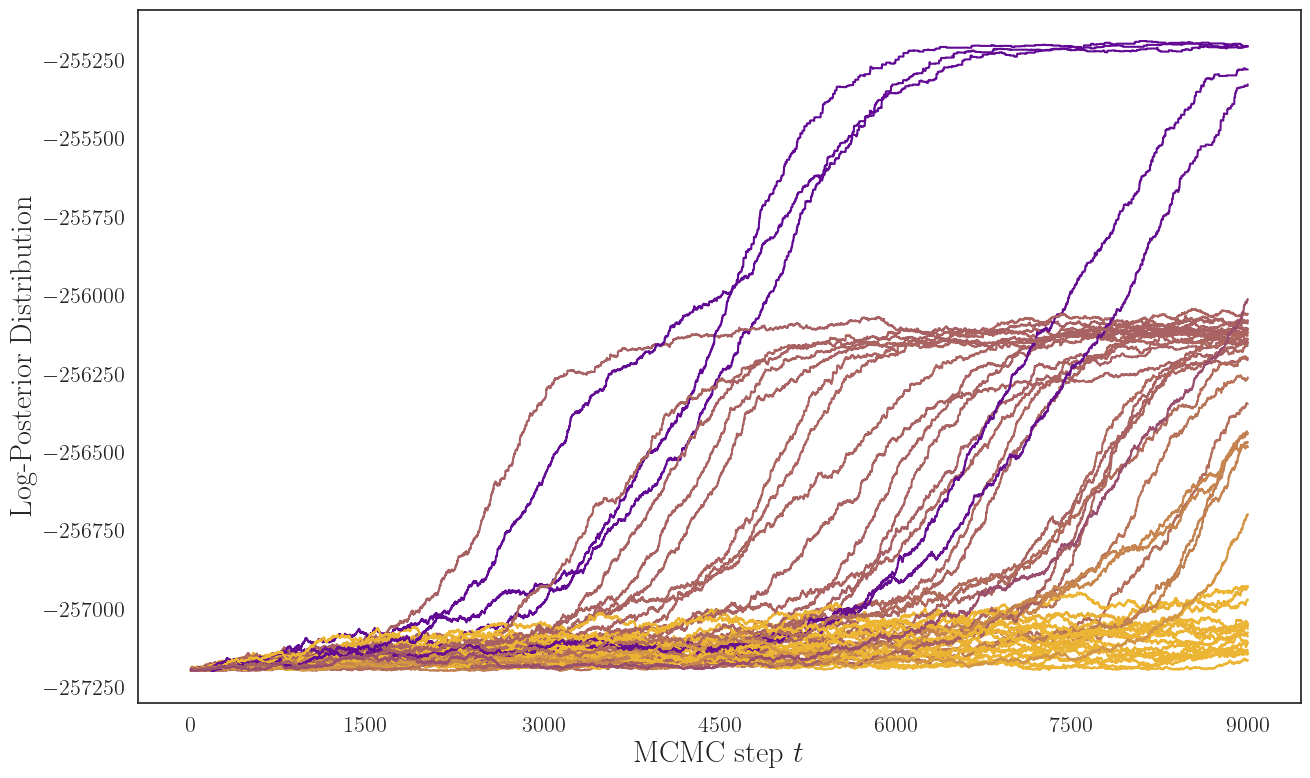

In [151]:
## p=0.40
plt.figure(figsize=(15,9))
for _ in range(repeat):
    color_array = df_color_classic.iloc[0,:]
    plt.plot(df_test40.loc[_,:], color=(1-color_array[_]*0.65, 0.80-color_array[_]*0.80, 0.15+color_array[_]*0.45))
    #plt.legend()
fig_name = "p=" + str(p_range[0]) + "," + "q=" + str(q) + "," + "repeat=" + str(repeat) + "," + "Classic_MH" + "," + "logPost"
x_major_locator = plt.MultipleLocator(1500)  # 以每15显示
#y_major_locator=MultipleLocator(3)  # 以每3显示
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
#ax.yaxis.set_major_locator(y_major_locator)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel(r"MCMC step $t$", fontsize = 22)
plt.ylabel(r"Log-Posterior\ Distribution", fontsize = 22)
#plt.title(fig_name)
save_file = "E:/学习/研三/Code/threshold_classic" + "/" + fig_name + ".jpg"
#plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

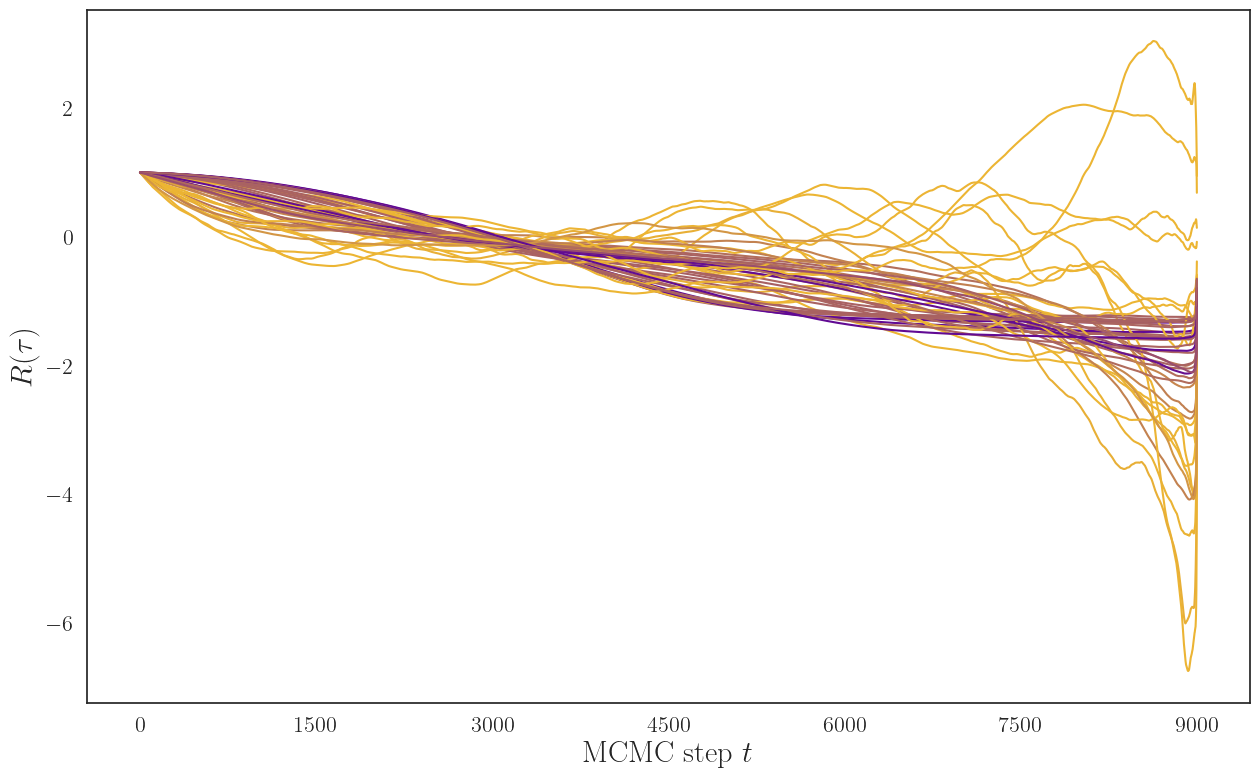

In [150]:
plt.figure(figsize=(15,9))
for _ in range(repeat):
    color_array = df_color_classic.iloc[0,:]
    x_i = range(len(Rtau_list_classic[0][_]))
    y_i = Rtau_list_classic[0][_]
    plt.plot(x_i, y_i, color=(1-color_array[_]*0.65, 0.80-color_array[_]*0.80, 0.15+color_array[_]*0.45))
    #color=(0.9-color_array[_]*0.7, 1-color_array[_]*0.5, 0.7+color_array[_]*0.15)
    #plt.legend()

fig_name = "p=" + str(p_range[0]) + "," + "q=" + str(q) + "," + "repeat=" + str(repeat) + "," + "Classic_MH" + "," + "Rtau"
x_major_locator = plt.MultipleLocator(1500)  # 以每15显示
#y_major_locator=MultipleLocator(3)  # 以每3显示
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
#ax.yaxis.set_major_locator(y_major_locator)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel(r"MCMC step $t$", fontsize = 22)
plt.ylabel(r"$R(\tau)$", fontsize = 22)
save_file = "E:/学习/研三/Code/threshold_classic" + "/" + fig_name + ".jpg"
#plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

In [101]:
df_test43 = pd.DataFrame(logpost_simple_list_classic[15])
print('p=', p_range[15])
df_test43.head()

p= 0.43


,0,1,2,3,4,5,6,7,8,9,...,8990,8991,8992,8993,8994,8995,8996,8997,8998,8999
0,-260040.692138,-260040.347013,-260040.896557,-260040.944703,-260040.985978,-260041.253010,-260041.464650,-260041.667583,-260041.263719,-260040.903778,...,-256615.002555,-256615.002555,-256615.002555,-256615.002555,-256615.002555,-256615.002555,-256615.002555,-256615.002555,-256615.002555,-256615.002555
1,-260040.010787,-260039.953154,-260040.112476,-260040.105215,-260040.281822,-260039.997633,-260040.064376,-260040.080895,-260040.102841,-260039.776440,...,-256813.454401,-256813.454401,-256813.454401,-256813.454401,-256813.454401,-256813.454401,-256813.454401,-256813.454401,-256813.454401,-256813.454401
2,-260041.492937,-260041.348240,-260041.243739,-260041.048523,-260040.942430,-260040.296482,-260040.301973,-260040.863981,-260041.031097,-260040.855335,...,-258376.091170,-258375.760683,-258375.989073,-258376.026274,-258376.026274,-258376.026274,-258376.026274,-258376.525723,-258377.055100,-258377.266491
3,-260041.407373,-260041.236987,-260041.776828,-260041.691052,-260041.281065,-260041.104763,-260040.802601,-260040.708734,-260040.941901,-260040.960003,...,-256612.989942,-256612.989942,-256612.989942,-256612.989942,-256612.989942,-256612.989942,-256612.989942,-256612.989942,-256612.989942,-256612.989942
4,-260041.065503,-260040.978583,-260040.830198,-260040.827347,-260040.344562,-260040.445994,-260040.651826,-260040.169952,-260040.394523,-260040.096011,...,-258344.347279,-258344.347279,-258344.903157,-258344.903157,-258344.903157,-258344.903157,-258343.767500,-258342.151337,-258342.151337,-258342.552346


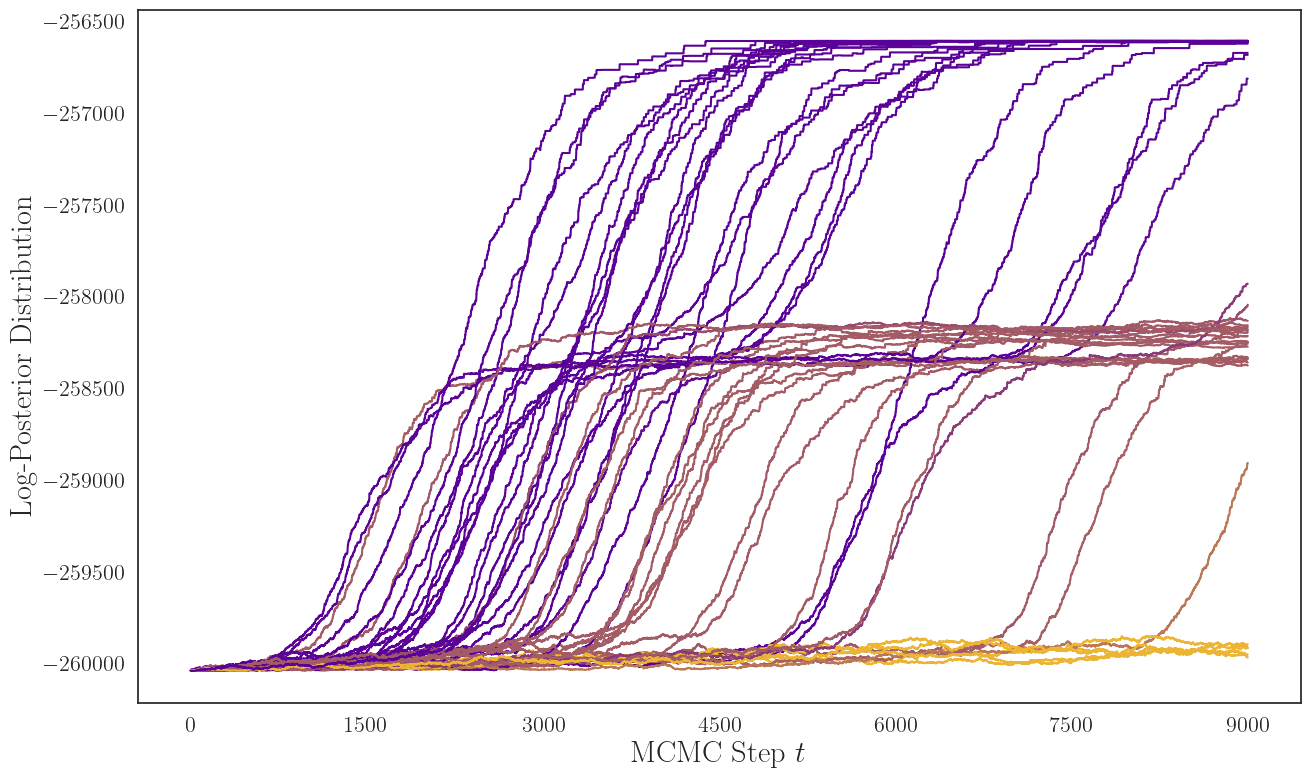

In [160]:
## p=0.43
plt.figure(figsize=(15,9))
for _ in range(repeat):
    color_array = df_color_classic.iloc[15,:]
    plt.plot(df_test43.loc[_,:], color=(1-color_array[_]*0.65, 0.80-color_array[_]*0.80, 0.15+color_array[_]*0.45))
    #plt.legend()
fig_name = "p=" + str(p_range[15]) + "," + "q=" + str(q) + "," + "repeat=" + str(repeat) + "," + "Classic_MH" + "," + "logPost"
x_major_locator = plt.MultipleLocator(1500)  # 以每15显示
#y_major_locator=MultipleLocator(3)  # 以每3显示
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
#ax.yaxis.set_major_locator(y_major_locator)
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel(r"MCMC Step $t$", fontsize = 22)
plt.ylabel(r"Log-Posterior Distribution", fontsize = 22)
#plt.title(fig_name)
save_file = "E:/学习/研三/Code/threshold_classic" + "/" + fig_name + ".jpg"
#plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

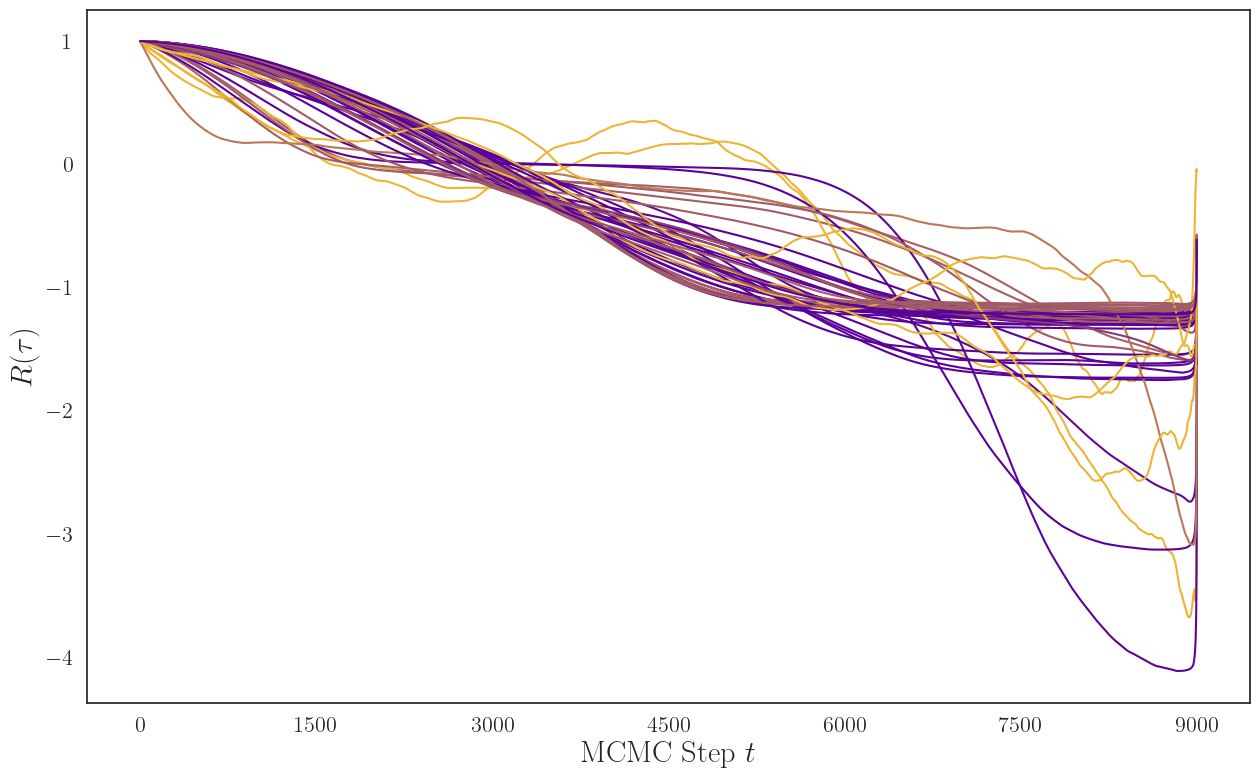

In [157]:
plt.figure(figsize=(15,9))
for _ in range(repeat):
    color_array = df_color_classic.iloc[15,:]
    x_i = range(len(Rtau_list_classic[15][_]))
    y_i = Rtau_list_classic[15][_]
    plt.plot(x_i, y_i, color=(1-color_array[_]*0.65, 0.80-color_array[_]*0.80, 0.15+color_array[_]*0.45))
    #color=(0.9-color_array[_]*0.7, 1-color_array[_]*0.5, 0.7+color_array[_]*0.15)
    #plt.legend()

fig_name = "p=" + str(p_range[15]) + "," + "q=" + str(q) + "," + "repeat=" + str(repeat) + "," + "Classic_MH" + "," + "Rtau"
x_major_locator = plt.MultipleLocator(1500)  # 以每15显示
#y_major_locator=MultipleLocator(3)  # 以每3显示
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
#ax.yaxis.set_major_locator(y_major_locator)
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel(r"MCMC Step $t$", fontsize = 22)
plt.ylabel(r"$R(\tau)$", fontsize = 22)
save_file = "E:/学习/研三/Code/threshold_classic" + "/" + fig_name + ".jpg"
#plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

In [97]:
df_test45 = pd.DataFrame(logpost_simple_list_classic[75])
print('p=', p_range[75])
df_test45.head()

p= 0.45


,0,1,2,3,4,5,6,7,8,9,...,8990,8991,8992,8993,8994,8995,8996,8997,8998,8999
0,-261941.846946,-261941.454539,-261941.096925,-261940.680503,-261940.659509,-261940.330872,-261940.481427,-261940.693486,-261941.396066,-261941.069337,...,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977
1,-261943.907993,-261944.108346,-261944.047253,-261943.782657,-261943.427725,-261943.535318,-261943.555324,-261943.542728,-261943.139893,-261943.129703,...,-261834.487202,-261834.118839,-261836.002625,-261835.910464,-261835.029923,-261836.051101,-261835.962937,-261838.829415,-261837.253347,-261836.942201
2,-261940.540016,-261940.419153,-261940.517476,-261941.140583,-261940.900286,-261940.710656,-261940.841512,-261940.509236,-261940.477727,-261940.551724,...,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977
3,-261944.005708,-261944.162448,-261943.932814,-261943.887897,-261943.890060,-261943.650530,-261943.394928,-261943.632208,-261943.182020,-261943.094822,...,-257645.703540,-257645.703540,-257645.703540,-257645.703540,-257645.703540,-257645.703540,-257645.703540,-257645.703540,-257645.703540,-257645.703540
4,-261943.926040,-261943.471408,-261943.002347,-261943.081158,-261942.914273,-261941.956976,-261941.767824,-261941.826097,-261941.553127,-261941.690570,...,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977,-257620.651977


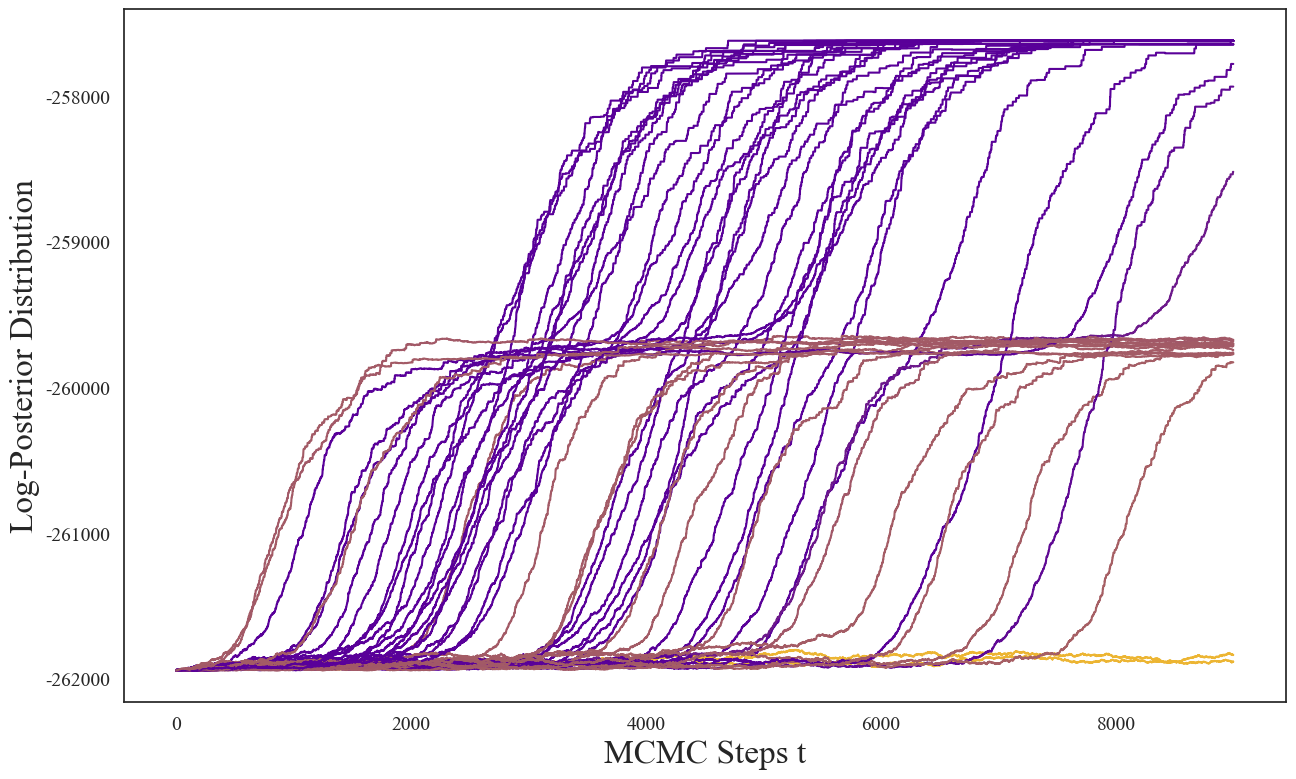

In [110]:
## p=0.45
plt.figure(figsize=(15,9))
for _ in range(repeat):
    color_array = df_color_classic.iloc[75,:]
    plt.plot(df_test45.loc[_,:], color=(1-color_array[_]*0.65, 0.80-color_array[_]*0.80, 0.15+color_array[_]*0.45))
    #plt.legend()
fig_name = "p=" + str(p_range[75]) + "," + "q=" + str(q) + "," + "repeat=" + str(repeat) + "," + "Classic_MH" + "," + "logPost"
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("MCMC Steps t", fontsize = 24)
plt.ylabel("Log-Posterior Distribution", fontsize = 24)
#plt.title(fig_name)
save_file = "E:/学习/研三/Code/threshold_classic" + "/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

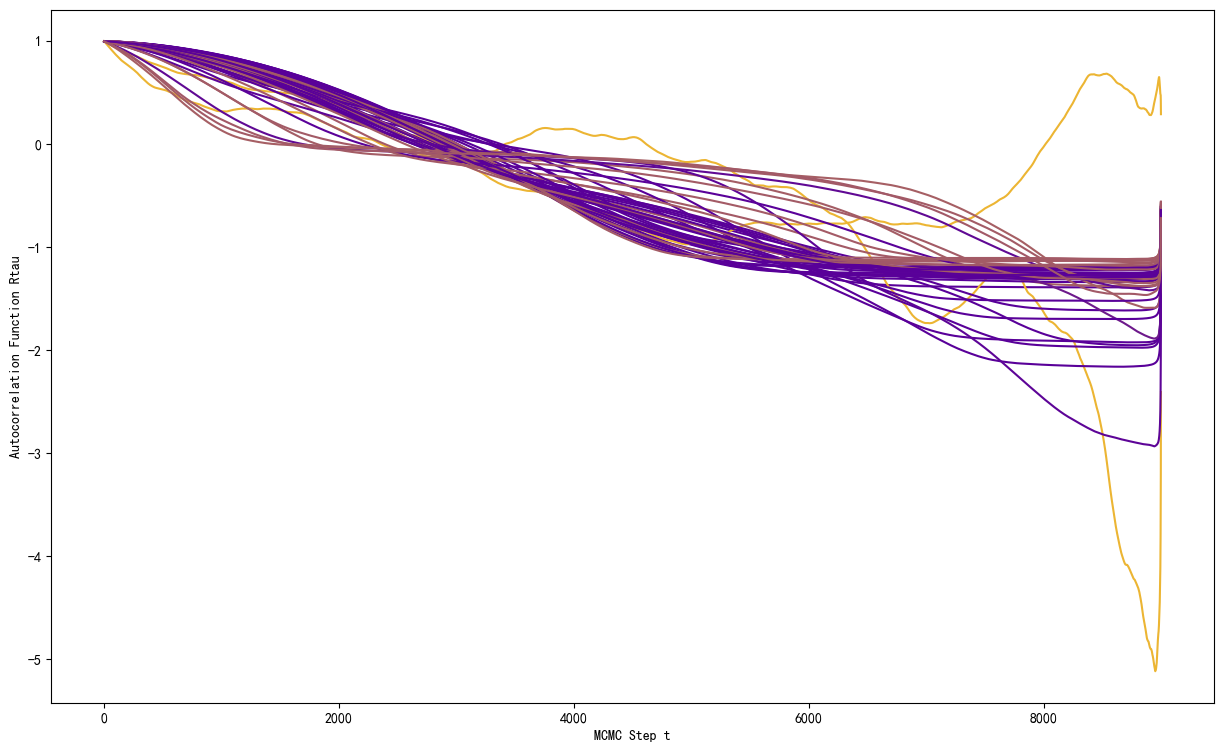

In [171]:
plt.figure(figsize=(15,9))
for _ in range(repeat):
    color_array = df_color_classic.iloc[75,:]
    x_i = range(len(Rtau_list_classic[75][_]))
    y_i = Rtau_list_classic[75][_]
    plt.plot(x_i, y_i, color=(1-color_array[_]*0.65, 0.80-color_array[_]*0.80, 0.15+color_array[_]*0.45))
    #color=(0.9-color_array[_]*0.7, 1-color_array[_]*0.5, 0.7+color_array[_]*0.15)
    #plt.legend()

fig_name = "p=" + str(p_range[25]) + "," + "q=" + str(q) + "," + "repeat=" + str(repeat) + "," + "Classic_MH" + "," + "Rtau"
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("MCMC Step t", fontsize = 24)
plt.ylabel("Autocorrelation Function Rtau", fontsize = 24)
save_file = "E:/学习/研三/Code/threshold_classic" + "/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

In [132]:
## 线条颜色，越深表示越好，青蓝配色
print(np.array([13,32,98])/255)      # 深色
print(np.array([253,254,212])/255)   # 浅色

[0.05098039 0.1254902  0.38431373]
[0.99215686 0.99607843 0.83137255]


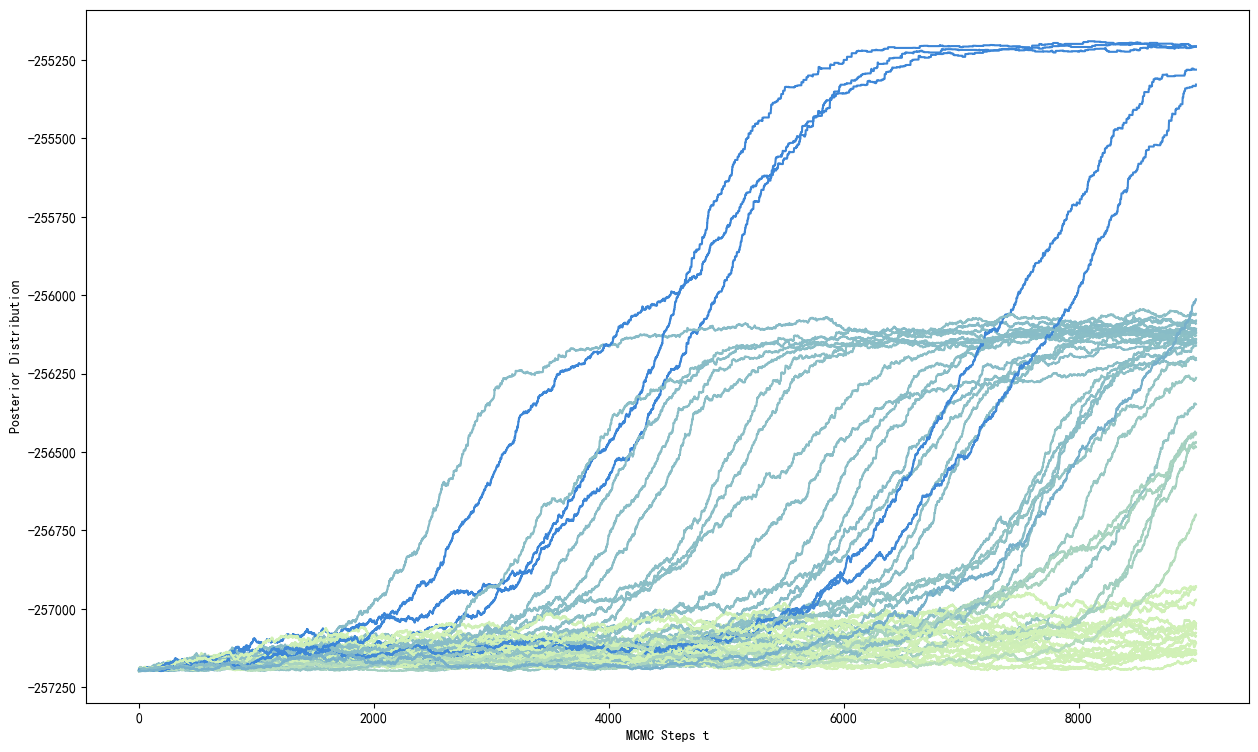

In [137]:
'''
暂时停用
'''
plt.figure(figsize=(15,9))
for _ in range(repeat):
    color_array = df_color_classic.iloc[0,:]
    #plt.plot(pd.DataFrame(logpost_simple_list_classic[10]).loc[_,:], color=(205/255, min_max_list2[_], min_max_list2[_]))
    plt.plot(df_test40.loc[_,:], color=(0.9-color_array[_]*0.7, 1-color_array[_]*0.5, 0.7+color_array[_]*0.15))
    #plt.legend()
fig_name = "p=" + str(p_range[0]) + "," + "q=" + str(q) + "," + "repeat=" + str(repeat) + "," + "logPost2"
plt.xlabel("MCMC Steps t")
plt.ylabel("Posterior Distribution")
#plt.title(fig_name)
save_file = "E:/学习/研三/Code/threshold_classic" + "/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

In [156]:
## 1, 2, 3分别对应无恢复，半恢复，全恢复
Rtau_cut1_meanfield = []
Rtau_cut2_meanfield = []
Rtau_cut3_meanfield = []
for i in range(len(p_range)):
    Rtau_cut_temp = Rtau_star_cut(Rtau_star_classic[i], finalRI_list_classic[i])
    Rtau_cut1_meanfield.append(Rtau_cut_temp[0])
    Rtau_cut2_meanfield.append(Rtau_cut_temp[1])
    Rtau_cut3_meanfield.append(Rtau_cut_temp[2])

In [179]:
df_Rtau_cut1_meanfield = pd.DataFrame(Rtau_cut1_meanfield)
df_Rtau_cut1_meanfield = np.transpose(df_Rtau_cut1_meanfield)
#df_Rtau_cut1_meanfield.insert(0,'RI',0.95)
print(len(df_Rtau_cut1_meanfield))
df_Rtau_cut1_meanfield.head()

50


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,1537.048229,1126.680623,731.166960,1207.326243,2167.338806,1509.797568,1079.835069,2413.877174,658.801839,2878.955672,...,1227.831578,1848.524640,1600.957048,1142.210793,1927.788686,NaN,2619.762993,1283.382813,1679.065909,NaN
1,1278.359127,1131.171333,1043.028586,1627.870949,902.785401,932.096048,1553.020392,1107.463109,1198.862149,946.635393,...,NaN,1213.065088,1252.085845,1508.443358,1773.180815,NaN,992.344382,903.504890,NaN,NaN
2,1696.042835,1210.182462,1380.230532,2120.374125,1248.249550,993.240986,2325.029060,905.400719,1209.860896,904.347209,...,NaN,1264.594847,NaN,NaN,1545.004334,NaN,NaN,NaN,NaN,NaN
3,1039.076135,775.675180,1581.261831,1082.658022,1472.044451,1375.198754,1485.301686,706.988663,2079.443555,2226.666704,...,NaN,1582.152380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1472.982868,1600.411616,801.727151,1690.857541,1847.500604,953.474480,1464.721666,793.794213,1353.828447,2374.456467,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
df_Rtau_cut2_meanfield = pd.DataFrame(Rtau_cut2_meanfield)
df_Rtau_cut2_meanfield = np.transpose(df_Rtau_cut2_meanfield)
#df_Rtau_cut2_meanfield.insert(0,'RI',0.75)
print(len(df_Rtau_cut2_meanfield))
df_Rtau_cut2_meanfield.head()

27


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1059.480050,1136.234186,1076.427394,1431.950750,1725.282171,1303.494435,884.247775,794.593720,1383.867159,1001.606986
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1089.537518,800.630328,1359.057963,1751.374871,1446.204927,776.769224,1613.002149,1309.243451,1653.675488,846.400330
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1753.782334,1812.073485,919.137928,1777.179115,1727.649377,1003.080612,1654.958041,1786.365949,1793.839363,1082.865021
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1765.536837,869.668723,1184.597416,910.399596,NaN,1426.168419,1465.201280,1631.353599,1255.148724,1765.808128
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,267.046353,1849.980442,1006.292794,1555.226837,NaN,1298.559057,1266.868003,923.810313,1839.948567,1215.921810


In [176]:
df_Rtau_cut3_meanfield = pd.DataFrame(Rtau_cut3_meanfield)
df_Rtau_cut3_meanfield = np.transpose(df_Rtau_cut3_meanfield)
#df_Rtau_cut3_meanfield.insert(0,'RI',0.50)
print(len(df_Rtau_cut3_meanfield))
df_Rtau_cut3_meanfield.head()

44


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1329.872902,1173.738361,1586.468145,1263.573067,1746.697449,1529.636349,1586.340738,1458.053449,1135.055967,1155.045610
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1813.227242,1777.012797,1611.554976,1053.678392,1423.052317,1069.805288,1753.893995,1436.329863,1247.305518,1148.735865
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1692.404681,1244.738873,1148.270497,1698.319586,739.420686,1706.295935,1447.776407,1465.518991,1331.750764,1746.082198
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,772.425904,1472.817202,1408.779301,1708.109987,1453.844784,1168.666944,1912.627420,1064.330660,1739.924311,1343.044226
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1727.871477,1028.782073,1916.957582,1859.754335,1131.588024,1302.882445,889.875904,1720.934413,1798.211430,1816.115173


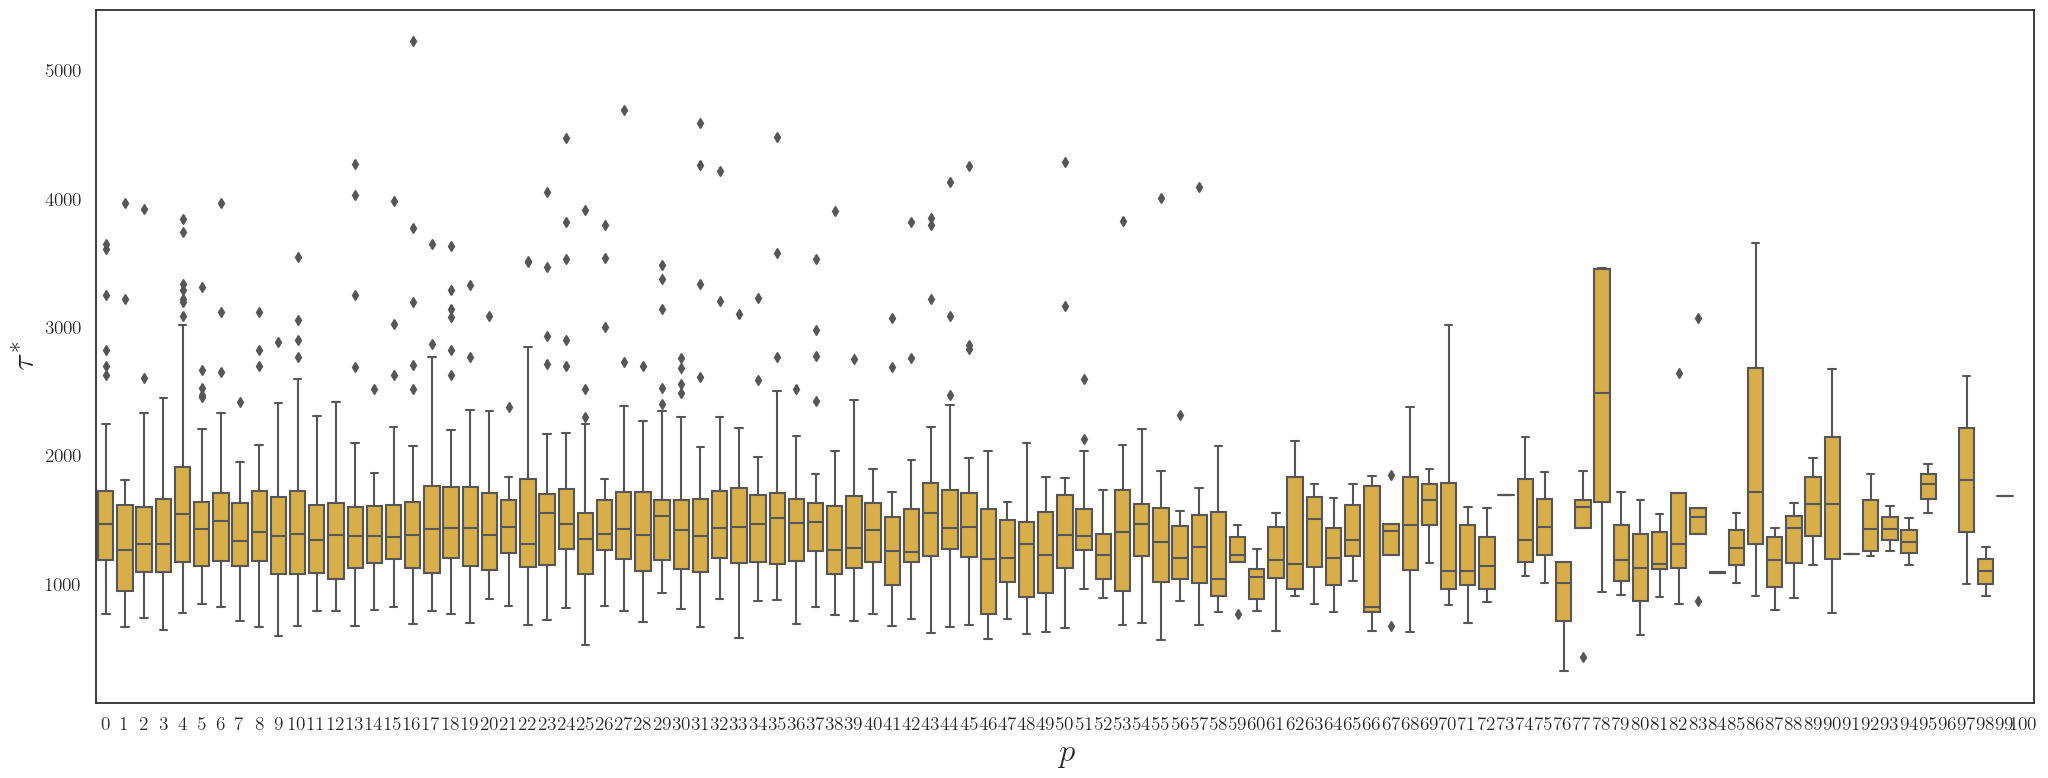

In [186]:
'''
恢复情况RI=0.55
'''
plt.figure(figsize=(25,9))
fig_name = 'n='+str(n) + ',' + 'p=' + str(p_range[0]) + '-' + str(p_range[-1]) + ',' + 'q='+str(q) +','+ 'repeat=' + str(repeat) + ',' + 'Classic_MH'+',' + 'tau_star3'

sns.boxplot(data = df_Rtau_cut1_meanfield, color=(1-0.10*0.65, 0.80-0.10*0.80, 0.15+0.10*0.45))

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel(r"$p$", fontsize = 24)
plt.ylabel(r"$\tau^*$", fontsize = 24)
save_file = "E:/学习/研三/Code/threshold_classic" + "/" + fig_name + ".jpg"
#plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

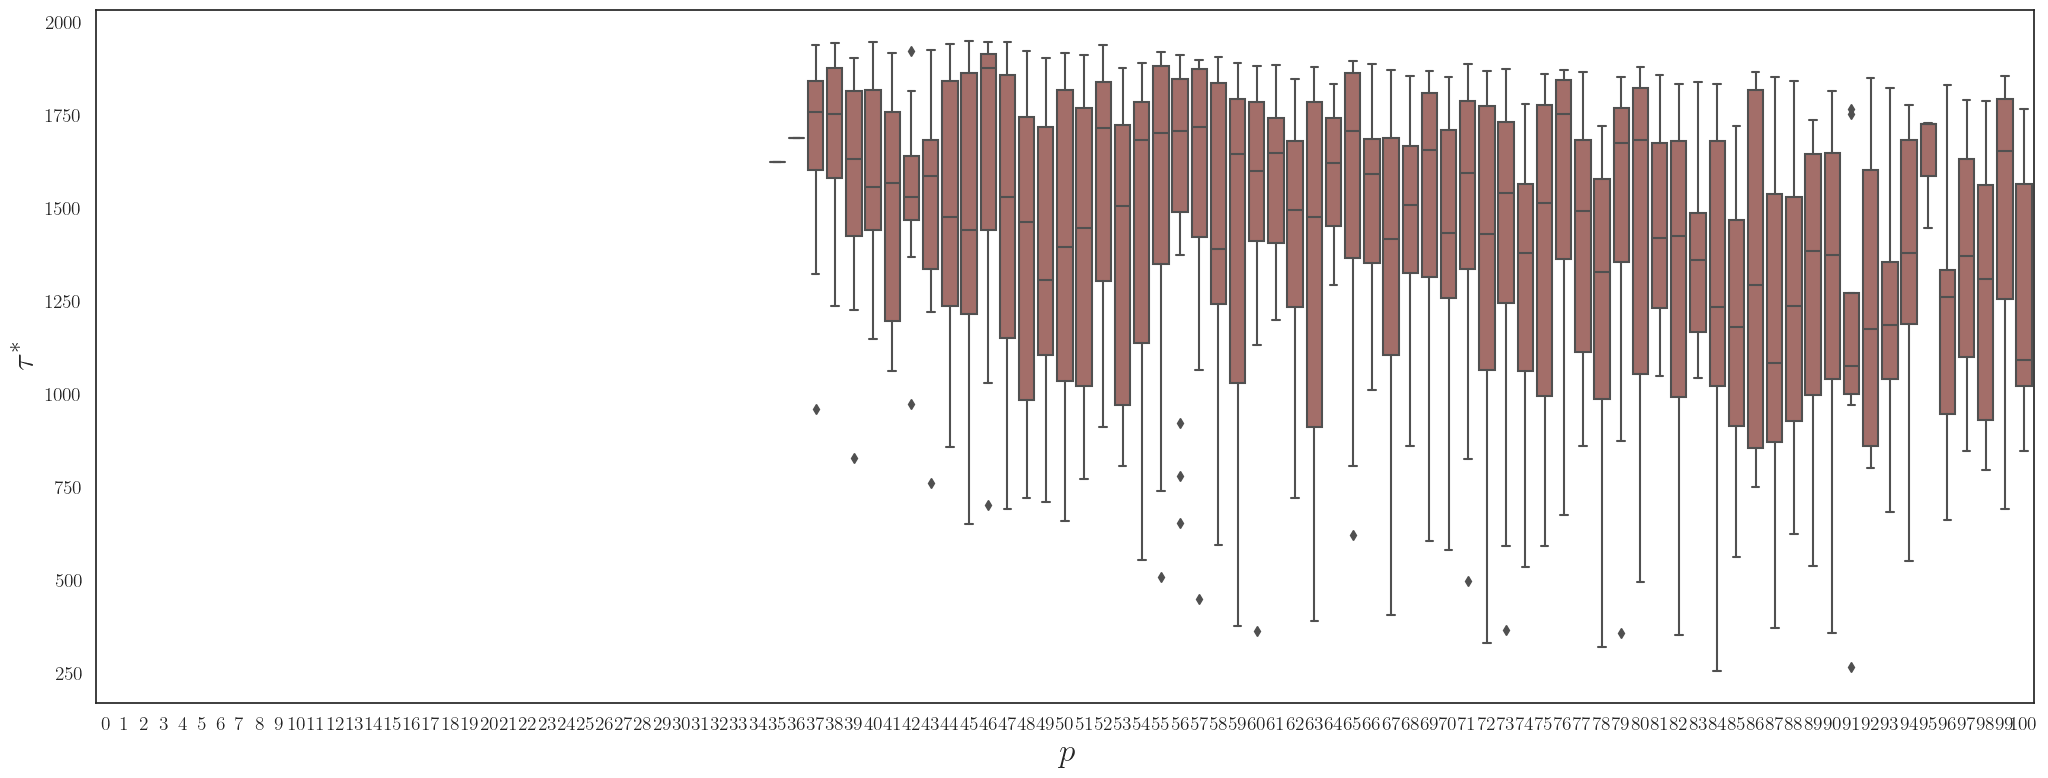

In [183]:
'''
恢复情况RI=0.75
'''
plt.figure(figsize=(25,9))
fig_name = 'n='+str(n) + ',' + 'p=' + str(p_range[0]) + '-' + str(p_range[-1]) + ',' + 'q='+str(q) +','+ 'repeat=' + str(repeat) + ',' + 'Classic_MH'+',' + 'tau_star2'

sns.boxplot(data = df_Rtau_cut2_meanfield, color=(1-0.50*0.65, 0.80-0.50*0.80, 0.15+0.50*0.45))

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel(r"$p$", fontsize = 24)
plt.ylabel(r"$\tau^*$", fontsize = 24)
save_file = "E:/学习/研三/Code/threshold_classic" + "/" + fig_name + ".jpg"
#plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

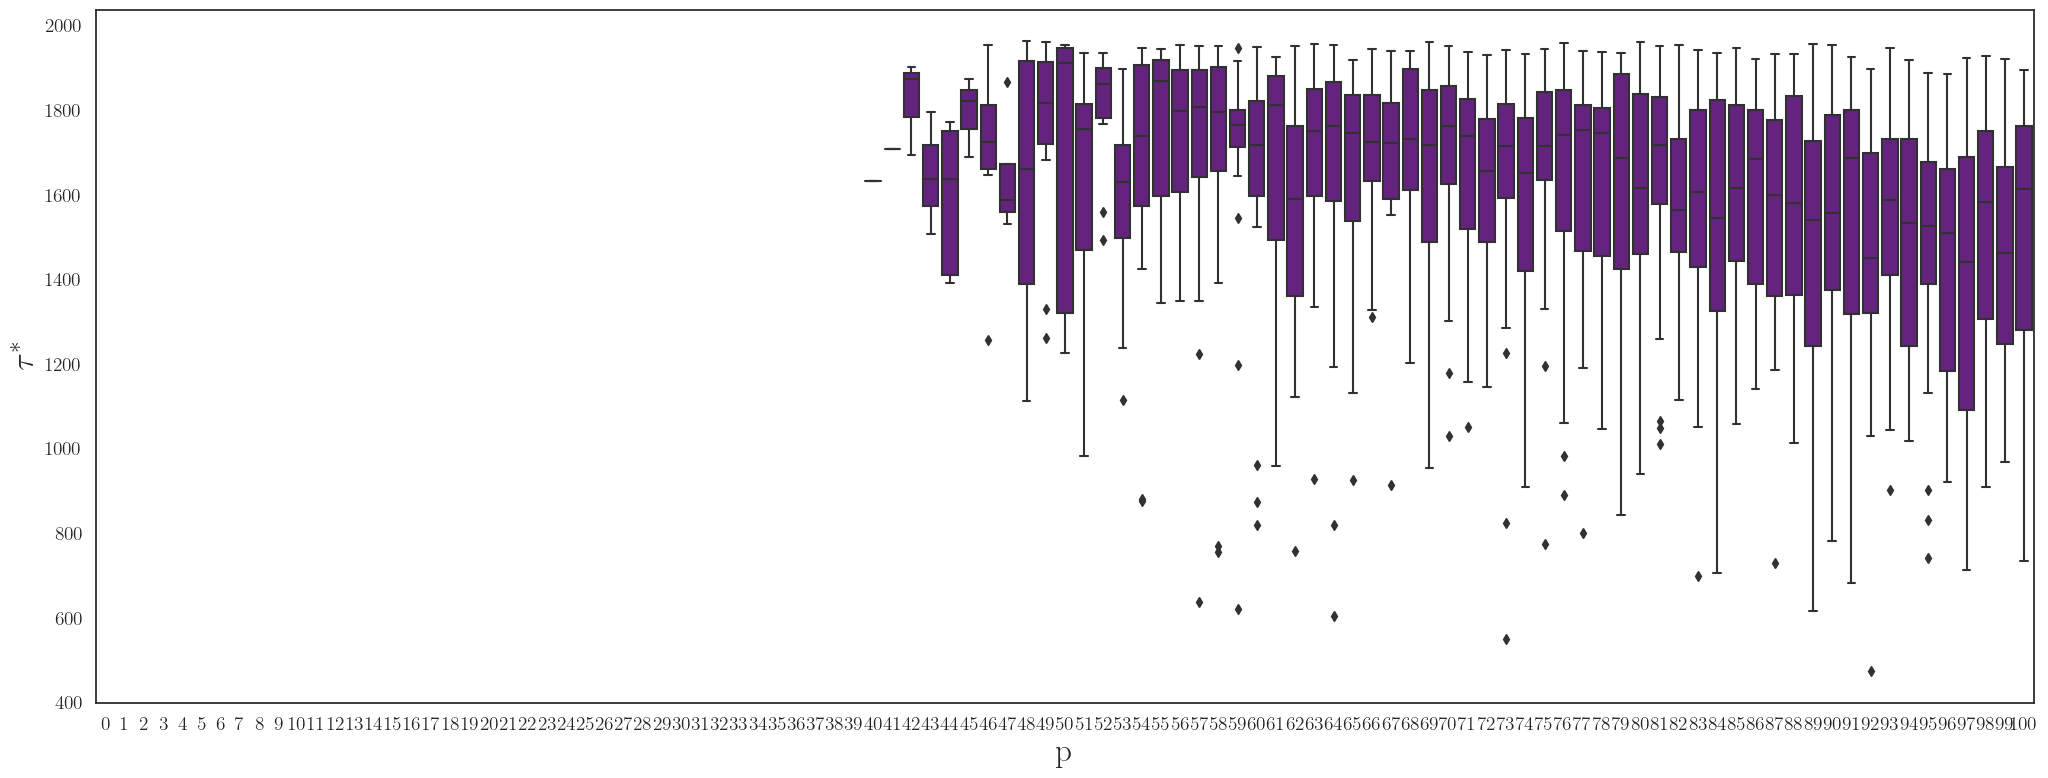

In [189]:
'''
恢复情况RI=0.95
'''
plt.figure(figsize=(25,9))
fig_name = 'n='+str(n) + ',' + 'p=' + str(p_range[0]) + '-' + str(p_range[-1]) + ',' + 'q='+str(q) +','+ 'repeat=' + str(repeat) + ',' + 'Classic_MH'+',' + 'tau_star1'

sns.boxplot(data = df_Rtau_cut3_meanfield, color=(1-0.90*0.65, 0.80-0.90*0.80, 0.15+0.90*0.45))

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("p", fontsize = 24)
plt.ylabel(r"$\tau^*$", fontsize = 24)
save_file = "E:/学习/研三/Code/threshold_classic" + "/" + fig_name + ".jpg"
#plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

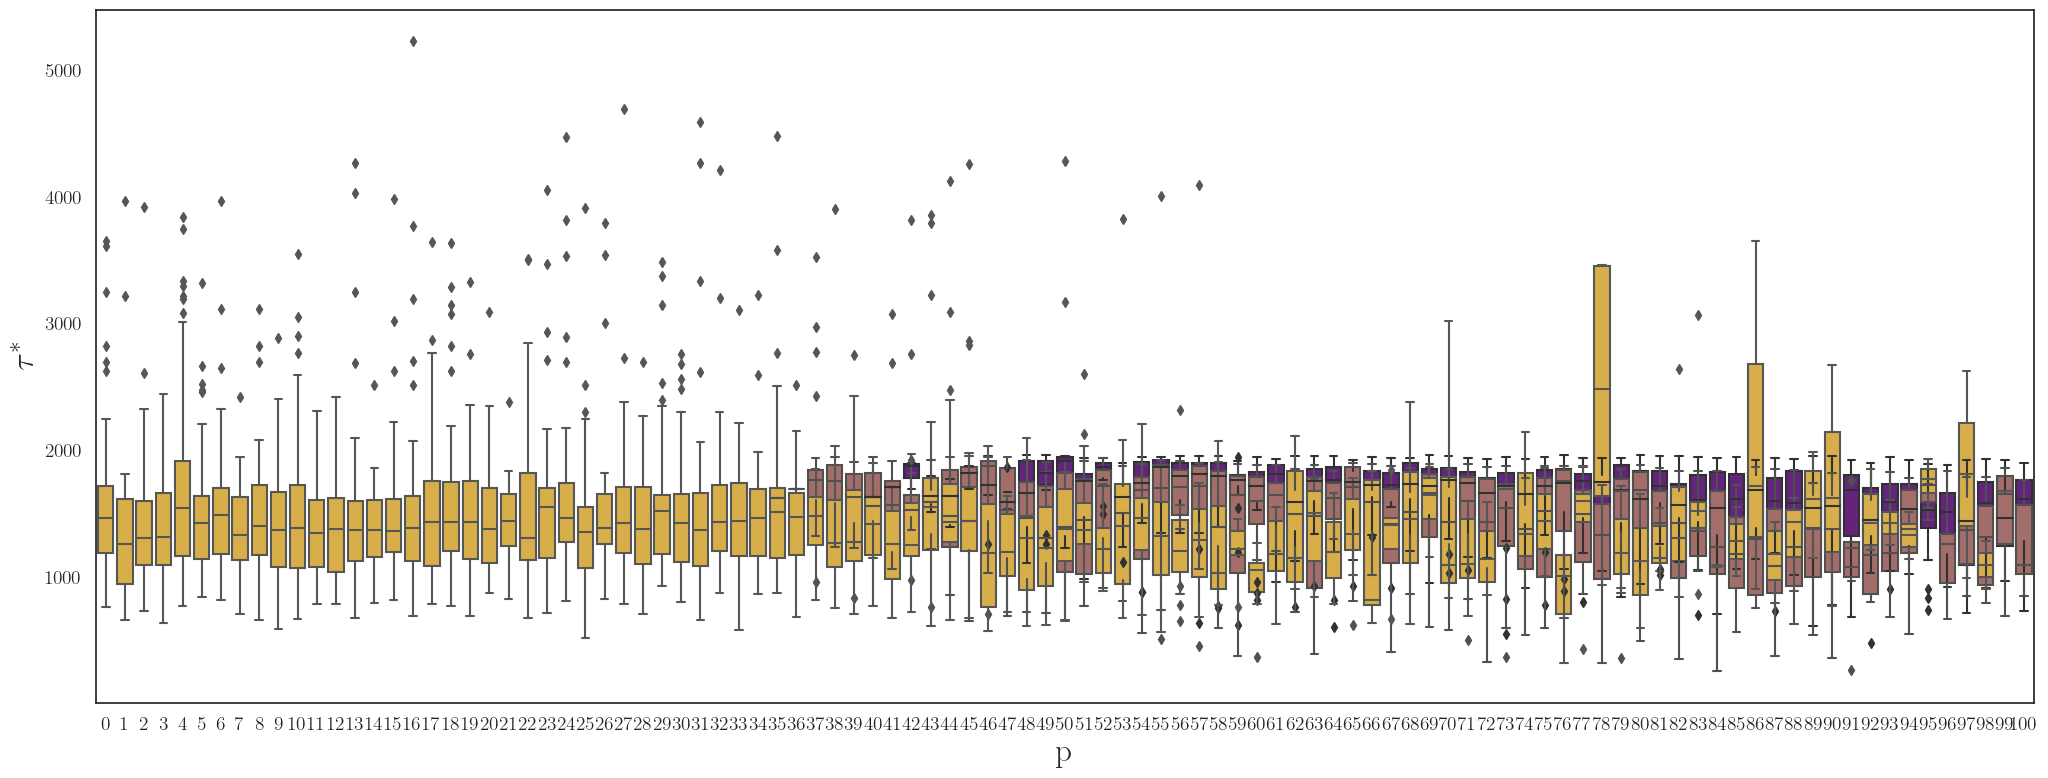

In [190]:
'''
恢复情况RI=0.95
'''
plt.figure(figsize=(25,9))
fig_name = 'n='+str(n) + ',' + 'p=' + str(p_range[0]) + '-' + str(p_range[-1]) + ',' + 'q='+str(q) +','+ 'repeat=' + str(repeat) + ',' + 'Classic_MH'+',' + 'tau_star1'

ax1 = sns.boxplot(data = df_Rtau_cut3_meanfield, color=(1-0.90*0.65, 0.80-0.90*0.80, 0.15+0.90*0.45))
ax2 = sns.boxplot(data = df_Rtau_cut2_meanfield, color=(1-0.50*0.65, 0.80-0.50*0.80, 0.15+0.50*0.45))
ax3 = sns.boxplot(data = df_Rtau_cut1_meanfield, color=(1-0.10*0.65, 0.80-0.10*0.80, 0.15+0.10*0.45))

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("p", fontsize = 24)
plt.ylabel(r"$\tau^*$", fontsize = 24)
save_file = "E:/学习/研三/Code/threshold_classic" + "/" + fig_name + ".jpg"
#plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()